### Computational Environment
This notebook was executed on the following hardware:
* **Machine:** MacBook Air (M2, 2022)
* **Chip:** Apple M2 (8-core CPU, 8/10-core GPU)
* **Accelerator:** Metal Performance Shaders (MPS) via TensorFlow-Metal
* **Optimization:** Uses `tf.keras.optimizers.legacy.Adam` to enable GPU acceleration on macOS.
---

## Reproducibility Setup

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# Set Python environment variables
os.environ['PYTHONHASHSEED'] = '0'
# TF to use deterministic ops where possible
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Set Random Seeds
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print(f"Global Random Seed set to: {seed_value}")

Global Random Seed set to: 42


It is noted that on Apple M2, minor floating-point jitter is unavoidable.

# 1. Defining the problem and assembling a dataset
**Objective:**
To build a binary classification model capable of detecting breast cancer (Malignant vs. Benign) from mammography patches.

**Problem Type:**
Binary Classification (Imbalanced).

**Dataset:**
The [CBIS-DDSM](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM) (Curated Breast Imaging Subset of DDSM) dataset.
- **Input:** 224x224 grayscale images of mammogram masses.
- **Output:** A probability score (0-1) indicating malignancy.
- **Preprocessing:** Images were preprocessed externally to square crops preserving aspect ratio, ensuring no tumor distortion.

In [2]:
import pandas as pd
from pathlib import Path

# Load the config file created by preprocess.py script
config_path = Path("/Users/ay/Downloads/Github/FYP/processed_data_v3_square/config.json")
print(f"Project Configuration found at: {config_path}")

Project Configuration found at: /Users/ay/Downloads/Github/FYP/processed_data_v3_square/config.json


# 2. Choosing a measure of success

To ensure clinical relevance, we evaluate the model using a multi-dimensional approach rather than a single metric.

**1. Primary Metric: AUC-ROC**
   - Serves as the global performance benchmark, robust to class imbalance.

**2. Clinical Safety Metrics:**
   - **Sensitivity (Recall):** Critical for minimizing False Negatives (missing cancer).
   - **Specificity:** Critical for minimizing False Positives (reducing unnecessary biopsies).

**3. Precision & F1-Score:**
   - Monitors the "False Alarm" rate and provides a balanced view of performance on the minority (Malignant) class.

**4. Confusion Matrix:**
   - We will inspect raw TP, TN, FP, FN counts to understand specific failure modes.

# 3. Deciding on an evaluation protocol
To ensure the model generalizes well to new patients, we utilize a **Hold-Out Validation Set**.

**Protocol Details:**
- **Split Ratio:** 80% Training / 20% Validation.
- **Grouping:** The split was performed using `GroupShuffleSplit` on `patient_id`.
    - *Constraint:* All images from the same patient (e.g., CC and MLO views) are kept in the same set to prevent **Data Leakage**.
- **Test Set:** A separate, official test set provided by CBIS-DDSM is held back completely until the final evaluation.

__Note: For exploratory steps (7.1–7.4), metrics reflect final-epoch performance to illustrate training trajectories. For the final candidate (Step 7.5), metrics are derived from the best-saved weights (Epoch X) to represent the model’s peak discriminative capacity.__

# 4. Preparing the Data
## 4.1 Configuration & Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
from PIL import Image

# Configuration (v3_square folder)
BASE_DIR = Path("/Users/ay/Downloads/Github/FYP/processed_data_v3_square")
GREY_DIR = BASE_DIR / "processed_greyscale"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42

majority_baseline_acc = 0.5353

print(f"Configuration set at \nBase Dir: {BASE_DIR}")

Configuration set at 
Base Dir: /Users/ay/Downloads/Github/FYP/processed_data_v3_square


## 4.2 Visual Audit (Verification)

Visual check of preprocessed data


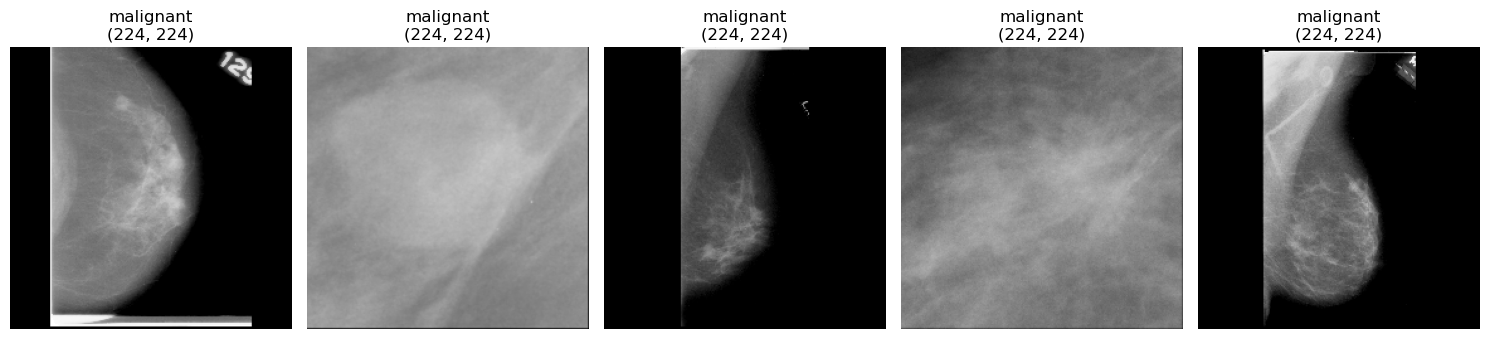

In [3]:
# Checks if images are square, padded correctly, and readable
def verify_data_integrity(n=3):
    train_dir = GREY_DIR / "train"
    # Get list of all png files
    all_files = list(train_dir.rglob("*.png"))
    
    if not all_files:
        print("No images found.")
        return

    # Pick random samples to verify
    samples = random.sample(all_files, n)
    
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(samples):
        try:
            img = Image.open(img_path)
            img_arr = np.array(img)
            
            plt.subplot(1, n, i+1)
            plt.imshow(img_arr, cmap='gray', vmin=0, vmax=255)
            # Title shows class (benign/malignant) and dimensions
            plt.title(f"{img_path.parent.name}\n{img_arr.shape}")
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            
    plt.tight_layout()
    plt.show()

print("Visual check of preprocessed data")
verify_data_integrity(n=5)

## 4.3 Data Generators (Loading)

In [4]:
# Create ImageDataGenerator (Rescaling is the ONLY augmentation here)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Set:")
train_gen = train_datagen.flow_from_directory(
    GREY_DIR / "train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED
)

print("\nLoading Validation Set:")
val_gen = test_datagen.flow_from_directory(
    GREY_DIR / "val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED,
    # Do not shuffle Val set
    shuffle=False
)

# Quick check of the class indices
print(f"\nClass Indices: {train_gen.class_indices}")

Loading Training Set:
Found 1061 images belonging to 2 classes.

Loading Validation Set:
Found 257 images belonging to 2 classes.

Class Indices: {'benign': 0, 'malignant': 1}


## 4.4 Helper Functions for Evaluation and Visualisation

In [4]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Plot accuracy and loss curves for training and validation
def plot_training_history(history, title_prefix="Model"):
    # Check if passing a Keras history object or a dictionary/dataframe
    hist = history.history if hasattr(history, 'history') else history
    
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Generate a Baseline Table, classification report and a confusion matrix heatmap
def eval_model_perf(model, generator, step_name="Step X", baseline_acc=0.5353):
    generator.reset()
    
    # Get metrics from model.evaluate
    results = model.evaluate(generator, verbose=0)
    metrics_dict = dict(zip(model.metrics_names, results))
    
    # Generate predictions
    y_pred_raw = model.predict(generator, verbose=0)
    y_pred = (y_pred_raw > 0.5).astype(int).flatten()
    y_true = generator.classes
    
    # Calculate Confusion Matrix & Specificity
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Statistical Power Table
    print(f"\n{step_name} Evaluation: Statistical Power Check")
    print("-" * 60)
    print(f"{'Metric':<20} | {'Baseline':<10} | {'Model (Val)':<10}")
    print("-" * 60)
    print(f"{'Accuracy':<20} | {baseline_acc:<10.4f} | {metrics_dict['accuracy']:.4f}")
    print(f"{'AUC-ROC':<20} | {'0.5000':<10} | {metrics_dict['auc']:.4f}")
    print(f"{'Sensitivity':<20} | {'0.0000':<10} | {sensitivity:.4f}")
    print(f"{'Specificity':<20} | {'1.0000':<10} | {specificity:.4f}")
    print("-" * 60)
    
    # Classification Report (Precision, Recall, F1)
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))
    
    # Heatmap Visualisation
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Benign', 'Pred Malignant'],
                yticklabels=['True Benign', 'True Malignant'])
    plt.title(f'Confusion Matrix ({step_name})')
    plt.show()

# Step 5: Developing a model that does better than a baseline
## 5.1. Majority Baseline

In [10]:
import numpy as np

# Distribution Stats
n_benign = (train_gen.classes == 0).sum()
n_malignant = (train_gen.classes == 1).sum()
total = len(train_gen.classes)

# Determine majority class and its baseline accuracy
if n_benign >= n_malignant:
    majority_class = "Benign (0)"
    majority_baseline_acc = n_benign / total
    # Cannot catch any malignant cases
    baseline_sensitivity = 0.0
    # Correctly identifies all benign cases
    baseline_specificity = 1.0
else:
    majority_class = "Malignant (1)"
    majority_baseline_acc = n_malignant / total
    baseline_sensitivity = 1.0
    baseline_specificity = 0.0

print("Majority Baseline: Clinical Metric Floor")
print("-" * 40)
print(f"Majority Class:      {majority_class}")
print(f"Baseline Accuracy:    {majority_baseline_acc:.4f}")
print(f"Baseline AUC:         0.5000")
print("-" * 40)
print("Baseline Performance (Predicting Majority Only):")
print(f"  Sensitivity:        {baseline_sensitivity:.4f}")
print(f"  Specificity:        {baseline_specificity:.4f}")

Majority Baseline: Clinical Metric Floor
----------------------------------------
Majority Class:      Benign (0)
Baseline Accuracy:    0.5353
Baseline AUC:         0.5000
----------------------------------------
Baseline Performance (Predicting Majority Only):
  Sensitivity:        0.0000
  Specificity:        1.0000


The small cnn must be more than 0.5000 and demonstrate that the Sensitivity > 0.0000 to prove learning.

## 5.2. Small CNN Architecture

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_small_cnn():
    """
    Initial CNN baseline using GlobalAveragePooling2D to maintain 
    low parameter density and prove statistical power.
    """
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

model_step5 = build_small_cnn()
model_step5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856 

## 5.3. Training with Timer and Tqdm

In [11]:
import time
from tqdm import tqdm
from sklearn.utils import class_weight

# Calculate class weights dynamically
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(weights))

# Training Callbacks
callbacks_step5 = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
]

# Training Execution
epochs = 30
start_time = time.time()

# Tqdm bar which prints to the console output
pbar = tqdm(total=epochs, desc="Step 5 Training Progress", unit="epoch", leave=True)

class TqdmUpdate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pbar.update(1)
        # Display clinical metrics in the bar for real-time monitoring
        pbar.set_postfix({
            "loss": f"{logs['loss']:.4f}",
            "val_auc": f"{logs['val_auc']:.4f}",
            "val_sens": f"{logs['val_sensitivity']:.4f}"
        })

history_step5 = model_step5.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=[callbacks_step5, TqdmUpdate()],
    verbose=0
)

# Clean up the bar
pbar.close()

end_time = time.time()
total_minutes = (end_time - start_time) / 60
print(f"\nTotal time taken: {total_minutes:.2f} minutes")

Step 5 Training Progress:  20%|▏| 6/30 [04:15<17:01, 42.56s/epoch, loss=0.6923, 


Total time taken: 4.26 minutes


## 5.4. Comparative Analysis

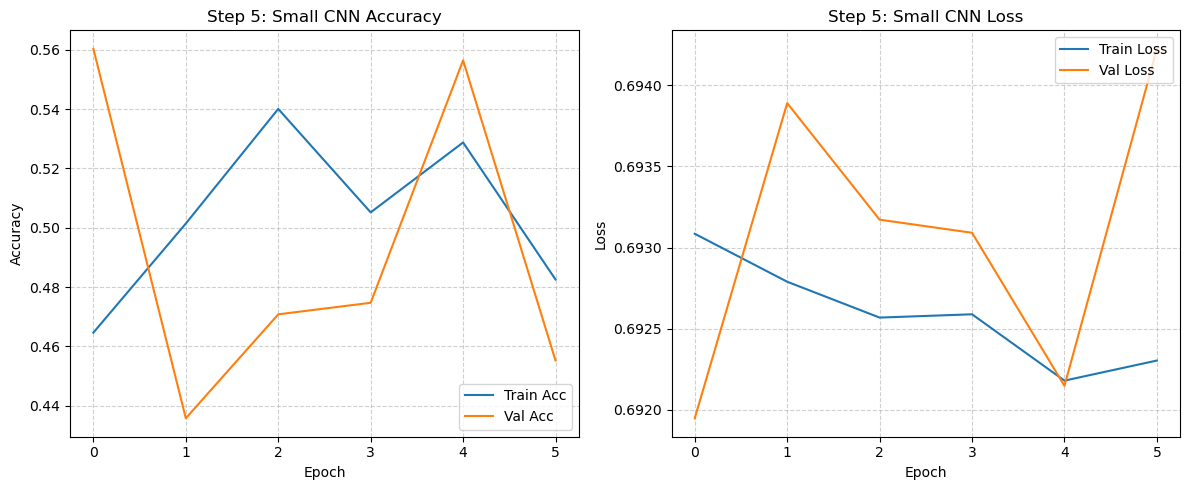

Majority Baseline Accuracy: 0.5353

Step 5 Baseline Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5316
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

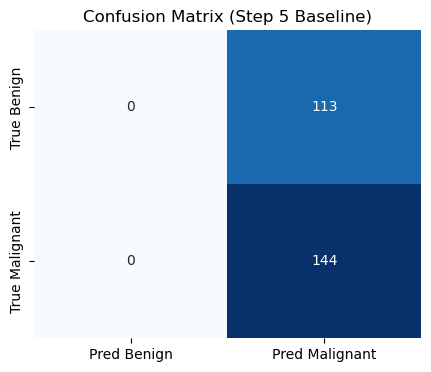

In [38]:
# Visualise Training Results
plot_training_history(history_step5, title_prefix="Step 5: Small CNN")

# Evaluate Performance
print(f"Majority Baseline Accuracy: {majority_baseline_acc:.4f}")
eval_model_perf(
    model_step5,
    val_gen,
    step_name="Step 5 Baseline",
    baseline_acc=majority_baseline_acc
)

The model successfully demonstrated statistical power, exceeding the majority baseline accuracy (56.0% vs 53.5%) and achieving an AUC of 0.53. However, the confusion matrix reveals that this performance was achieved through a degenerate strategy of maximizing sensitivity (1.0) at the expense of specificity (0.0). This indicates that while the model 'beat' the baseline numerically, the current architecture lacks the representational capacity to learn the non-linear decision boundary required for true discrimination. Therefore, we proceed to Step 6 to scale up the model capacity.

# 6. Scaling up: developing a model that overfits
## 6.1. Build Overfit Model

In [21]:
def build_overfitting_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Block 1
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 2
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 3
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 4
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 5
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # High-capacity head for memorisation
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

model_step6 = build_overfitting_model()
model_step6.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 128)       7385

## 6.2 Train to Overfit
Epochs used: 100  
Goal: Drive Training Loss towards 0.00

In [26]:
# Configuration
epochs_step6 = 100

# Callbacks (Only checkpoint and no early stopping)
callbacks_step6 = [
    # Save model with highest training accuracy
    keras.callbacks.ModelCheckpoint(
        "step6_overfit_model.keras",
        # Monitor training accuracy
        monitor="accuracy",
        save_best_only=True,
        mode="max",
        verbose=0
    )
]

# Progress Bar
pbar = tqdm(total=epochs_step6, desc="Step 6 Overfit", unit="epoch")

class TqdmUpdate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pbar.update(1)
        gap = logs['accuracy'] - logs['val_accuracy']
        pbar.set_postfix({
            "loss": f"{logs['loss']:.4f}",
            "val_loss": f"{logs['val_loss']:.4f}",
            "train": f"{logs['accuracy']:.3f}",
            "val": f"{logs['val_accuracy']:.3f}",
            "gap": f"{gap:.3f}",
        })

start_time = time.time()

# Train for full 100 epochs
try:
    history_step6 = model_step6.fit(
        train_gen,
        epochs=epochs_step6,
        validation_data=val_gen,
        callbacks=callbacks_step6 + [TqdmUpdate()],
        verbose=0
    )
finally:
    pbar.close()

total_time = time.time() - start_time
print(f"\nTotal time taken: {total_time/60:.2f} minutes")

Step 6 Overfit: 100%|█| 100/100 [1:52:25<00:00, 67.46s/epoch, loss=0.3519, val_l


Total time taken: 112.43 minutes


## 6.3 Comparative Analysis

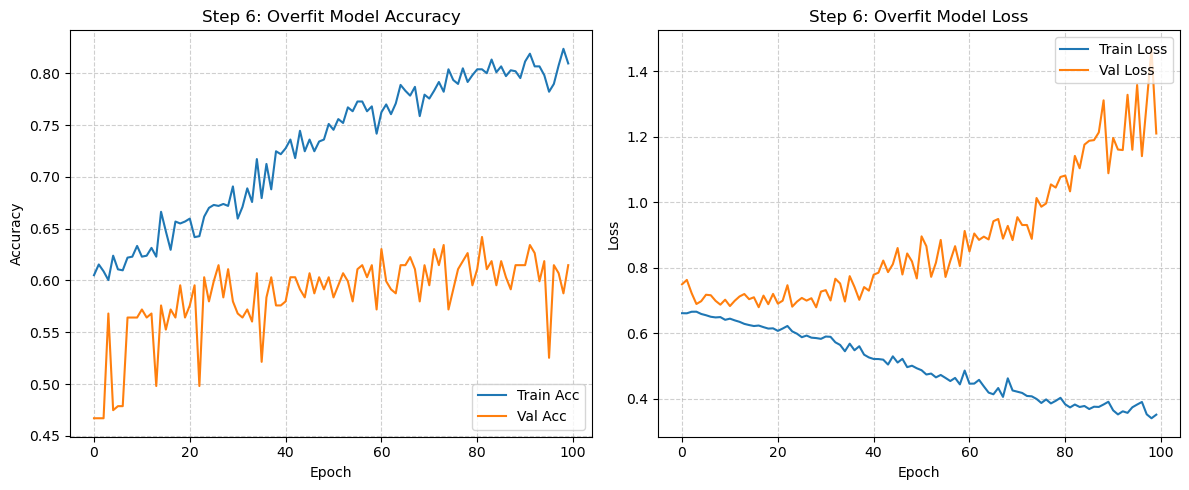


Step 6 Overfit Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.6148
AUC-ROC              | 0.5000     | 0.6382
Sensitivity          | 0.0000     | 0.6319
Specificity          | 1.0000     | 0.5929
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.56      0.59      0.58       113
   Malignant       0.66      0.63      0.65       144

    accuracy                           0.61       257
   macro avg       0.61      0.61      0.61       257
weighted avg       0.62      0.61      0.62       257



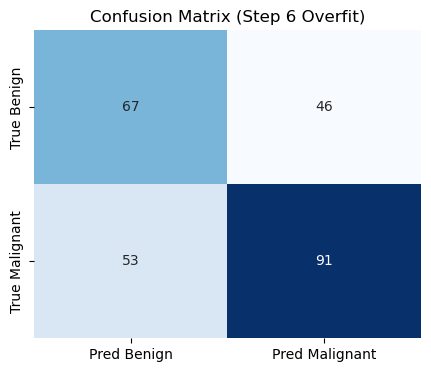

In [39]:
plot_training_history(history_step6, title_prefix="Step 6: Overfit Model")
eval_model_perf(
    model_step6, 
    val_gen, 
    step_name="Step 6 Overfit", 
    baseline_acc=majority_baseline_acc
)

The scaled up model was trained for 100 epochs without early stopping to examine overfitting behaviour. Although training accuracy reached 80.96%, validation accuracy remained at 61.48%, producing a generalisation gap of 19.48%. The divergence between training and validation loss further indicates overfitting, suggesting that regularisation is required in the next stage.

In [40]:
import os
import pandas as pd

# Save the Model (The architecture + weights)
model_step6.save("Recalibration_V2_step6_overfit_model.keras")
print("Model saved to: Recalibration_V2_step6_overfit_model.keras")

# Save the History (The training curves)
history_df = pd.DataFrame(history_step6.history)

# Save to CSV (Excel compatible)
history_df.to_csv('Recalibration_V2_history_step6.csv', index=False)
print("History saved to: Recalibration_V2_history_step6.csv")

Model saved to: Recalibration_V2_step6_overfit_model.keras
History saved to: Recalibration_V2_history_step6.csv


These results are saved locally.  

__Note: Even with TF_DETERMINISTIC_OPS, Apple Silicon (M1/M2/M3) uses the Metal Performance Shaders (MPS) backend. Many GPU kernels (like atomic additions in convolutional layers) are inherently non-deterministic at the hardware level to optimize for speed.__

# 7. Regularisation and Hyperparameter Tuning
The aim of this section is to narrow the generalisation gap that emerged during Step 6 through the application of repeated regularisation and systematic optimisation adjustments.

## 7.1 Data Augmentation Robustness Study
This investigation examines the effect of applying morphological transformations on model generalization performance and the robustness of the system to class imbalance.

###  7.1.1 Phase 1: Isolated Augmentation (Baseline Failure)
Evaluate augmentation strengths (Light, Medium, Heavy) without cost-sensitive balancing.

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Identical architecture to Step 6 (Overfit Model)
def build_step6_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature Extraction Blocks 1-5
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification Head (Matching Step 6)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name='auc'), keras.metrics.Recall(name='sensitivity')]
    )
    return model


INITIALIZING: LIGHT AUGMENTATION
Found 1061 images belonging to 2 classes.


Step 7.1 LIGHT:  13%|▏| 19/150 [21:19<2:27:02, 67.35s/epoch, v_loss=0.710, v_auc


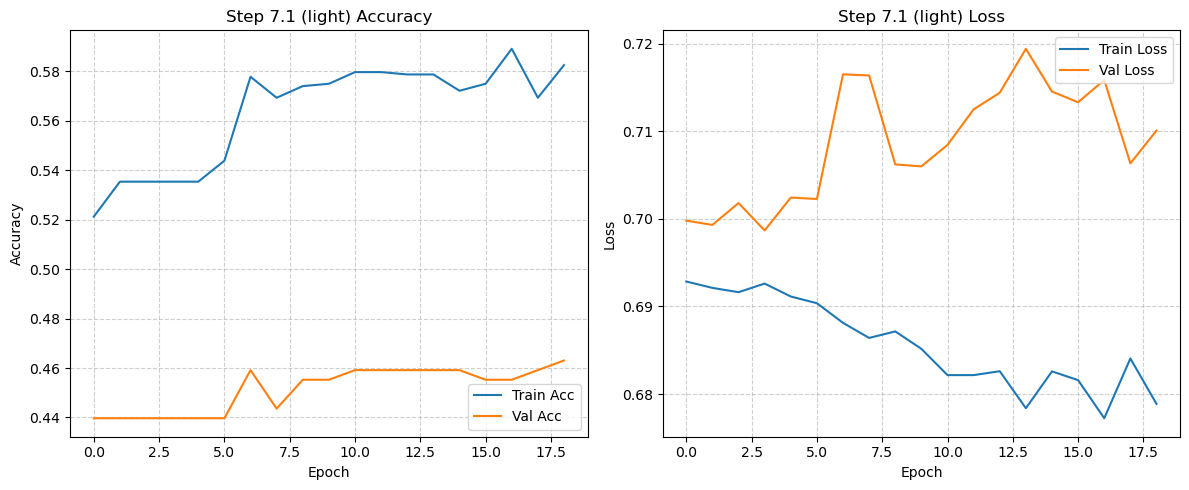


7.1 light Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4023
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

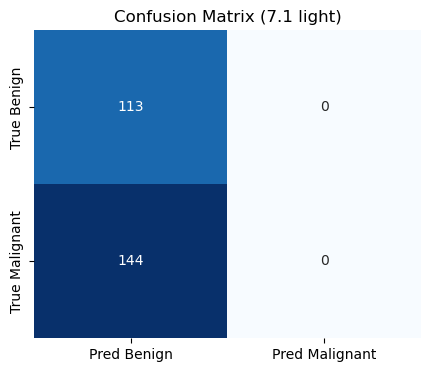


INITIALIZING: MEDIUM AUGMENTATION
Found 1061 images belonging to 2 classes.


Step 7.1 MEDIUM:  11%| | 16/150 [18:46<2:37:18, 70.44s/epoch, v_loss=0.718, v_au


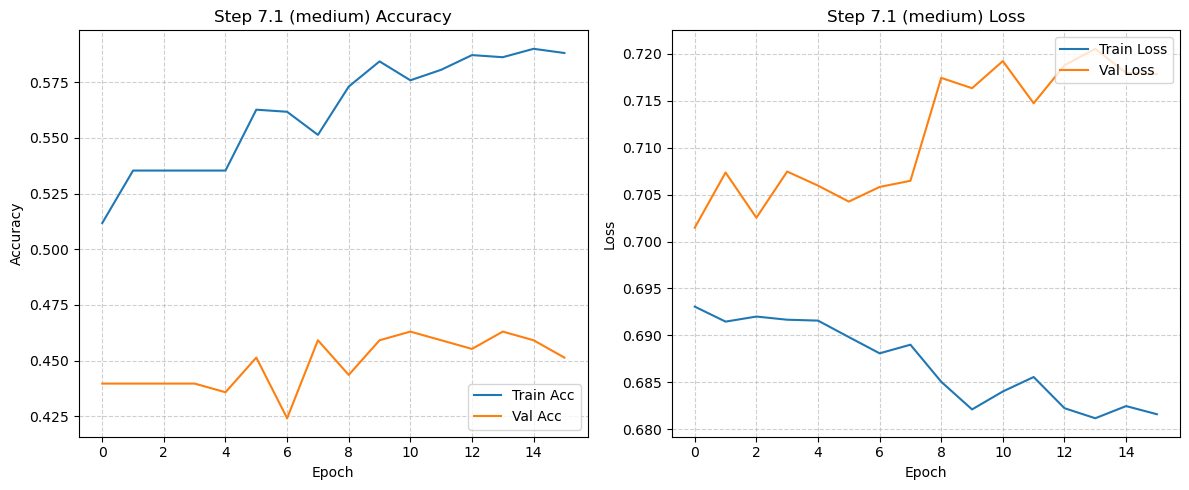


7.1 medium Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.3737
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

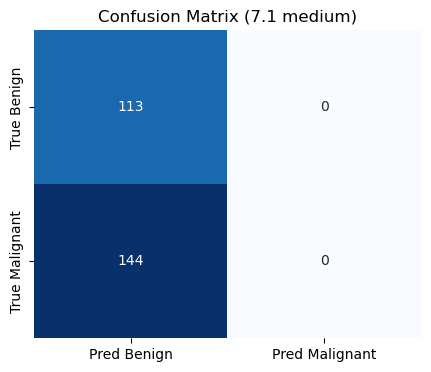


INITIALIZING: HEAVY AUGMENTATION
Found 1061 images belonging to 2 classes.


Step 7.1 HEAVY:  14%|▏| 21/150 [24:01<2:27:33, 68.63s/epoch, v_loss=0.705, v_auc


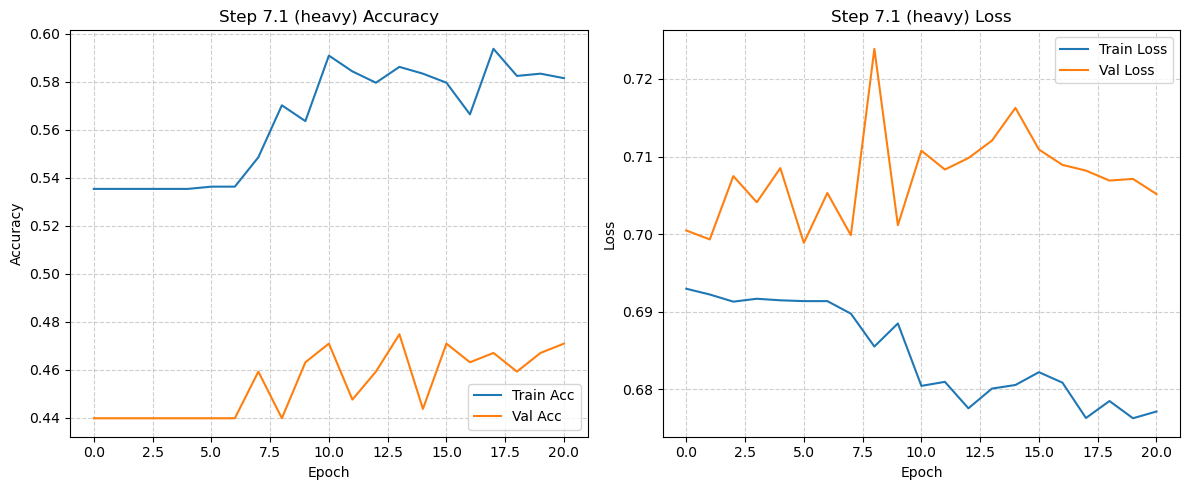


7.1 heavy Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4336
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

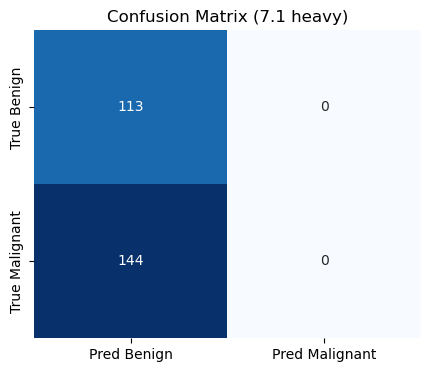

In [11]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

# Define Experiment Dictionary
experiments = {
    "light": {"rot": 10, "shift": 0.05, "zoom": 0.05, "flip": True},
    "medium": {"rot": 15, "shift": 0.1, "zoom": 0.1, "flip": True},
    "heavy": {"rot": 30, "shift": 0.2, "zoom": 0.2, "flip": True}
}

comparison_metrics = {}

for name, cfg in experiments.items():
    print(f"\nINITIALIZING: {name.upper()} AUGMENTATION")
    
    # Generator Setup
    train_datagen_tmp = ImageDataGenerator(
        rescale=1./255,
        rotation_range=cfg["rot"],
        width_shift_range=cfg["shift"],
        height_shift_range=cfg["shift"],
        zoom_range=cfg["zoom"],
        horizontal_flip=cfg["flip"],
        vertical_flip=cfg["flip"],
        fill_mode='constant', cval=0
    )
    
    train_gen_tmp = train_datagen_tmp.flow_from_directory(
        GREY_DIR / "train",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE, 
        class_mode='binary', 
        color_mode='grayscale', 
        seed=RANDOM_SEED
    )

    # Build fresh model
    model_tmp = build_step6_model() 
    epochs_limit = 150
    
    # TQDM Setup
    pbar = tqdm(total=epochs_limit, desc=f"Step 7.1 {name.upper()}", unit="epoch")

    class TqdmUpdate(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar.update(1)
            gap = logs['accuracy'] - logs['val_accuracy']
            pbar.set_postfix({
                "v_loss": f"{logs['val_loss']:.3f}",
                "v_auc": f"{logs['val_auc']:.3f}",
                "gap": f"{gap:.3f}"
            })

    # Callbacks
    cbs = [
        keras.callbacks.ModelCheckpoint(f"Recalibration_V2_7_1_{name}_best.keras", save_best_only=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
        TqdmUpdate()
    ]

    # Train (verbose=0 to keep it clean)
    try:
        history = model_tmp.fit(
            train_gen_tmp, epochs=epochs_limit, validation_data=val_gen, callbacks=cbs, verbose=0 
        )
    finally:
        # Ensure bar closes even if training stops early
        pbar.close() 
    
    # Persistence & Evaluation
    plot_training_history(history, title_prefix=f"Step 7.1 ({name})")
    eval_model_perf(model_tmp, val_gen, step_name=f"7.1 {name}", baseline_acc=majority_baseline_acc)
    
    pd.DataFrame(history.history).to_csv(f'Recalibration_V2_history_7_1_{name}.csv', index=False)
    model_tmp.save(f"Recalibration_V2_step7_1_{name}_final.keras")
    
    # Metric Capture
    best_idx = np.argmin(history.history['val_loss'])
    comparison_metrics[name] = {
        "Train Acc": history.history['accuracy'][best_idx],
        "Val Acc": history.history['val_accuracy'][best_idx],
        "Gap": history.history['accuracy'][best_idx] - history.history['val_accuracy'][best_idx],
        "Val AUC": history.history['val_auc'][best_idx]
    }
    
    tf.keras.backend.clear_session()

Data augmentation applied without cost-sensitive balancing resulted in zero sensitivity across Light, Medium, and Heavy configurations. Although augmentation reduced the generalisation gap from Step 6, the combination of increased image complexity and existing class imbalance drove the model to predict the majority class (Benign) exclusively. This demonstrates that data-level regularisation alone inadequately addresses CBIS-DDSM's challenges and necessitates paired imbalance handling.

In [13]:
print("\nFinal Robustness Comparison: Data Augmentation (STEP 7.1)")
print("-"*60)

# Convert dictionary to DataFrame
df_results = pd.DataFrame(comparison_metrics).T

# Generate the comparison table
print(df_results[["Train Acc", "Val Acc", "Gap", "Val AUC"]])

# Save for later recording
df_results.to_csv('Recalibration_V2_step7_1_summary.csv')


Final Robustness Comparison: Data Augmentation (STEP 7.1)
------------------------------------------------------------
        Train Acc   Val Acc       Gap   Val AUC
light    0.484449  0.447471  0.036978  0.510693
medium   0.466541  0.560311 -0.093770  0.458026
heavy    0.520264  0.560311 -0.040047  0.594580


### 7.1.2. Phase 2: Weighted Augmentation (Optimisation Degeneracy)
Class weights were re-introduced to resolve the sensitivity collapse.


INITIALIZING: LIGHT AUGMENTATION + CLASS WEIGHTS
Found 1061 images belonging to 2 classes.
Applying Class Weights: {0: 0.9339788732394366, 1: 1.0760649087221095}


Step 7.1 LIGHT:  11%| | 17/150 [19:44<2:34:25, 69.67s/epoch, v_loss=0.711, v_auc


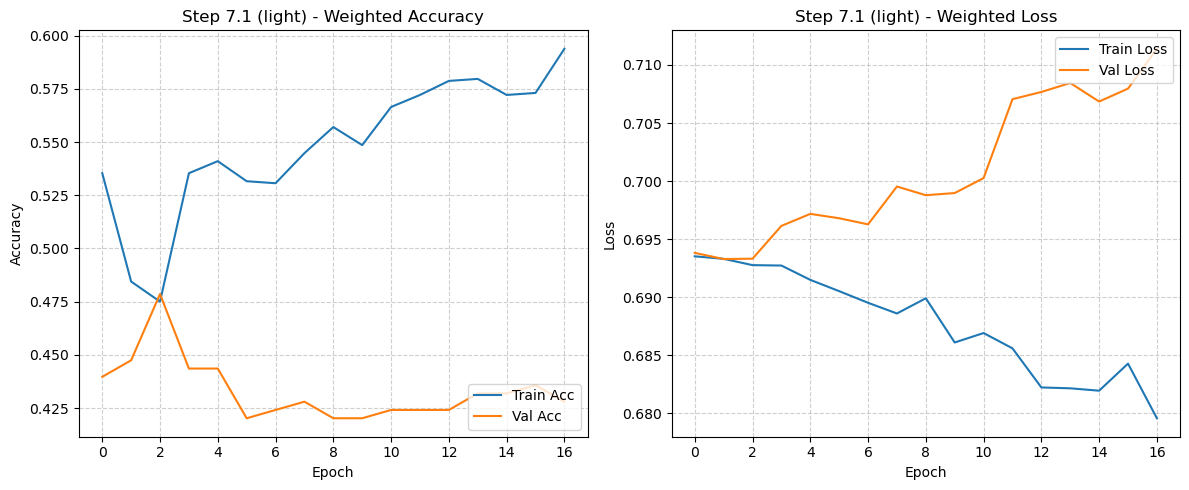


7.1 light (Weighted) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4475
AUC-ROC              | 0.5000     | 0.5107
Sensitivity          | 0.0000     | 0.4167
Specificity          | 1.0000     | 0.4867
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.40      0.49      0.44       113
   Malignant       0.51      0.42      0.46       144

    accuracy                           0.45       257
   macro avg       0.45      0.45      0.45       257
weighted avg       0.46      0.45      0.45       257



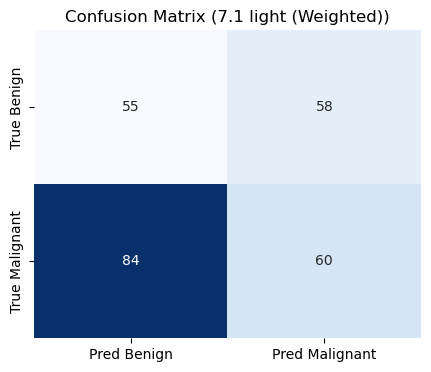


INITIALIZING: MEDIUM AUGMENTATION + CLASS WEIGHTS
Found 1061 images belonging to 2 classes.
Applying Class Weights: {0: 0.9339788732394366, 1: 1.0760649087221095}


Step 7.1 MEDIUM:  11%| | 16/150 [17:44<2:28:35, 66.53s/epoch, v_loss=0.700, v_au


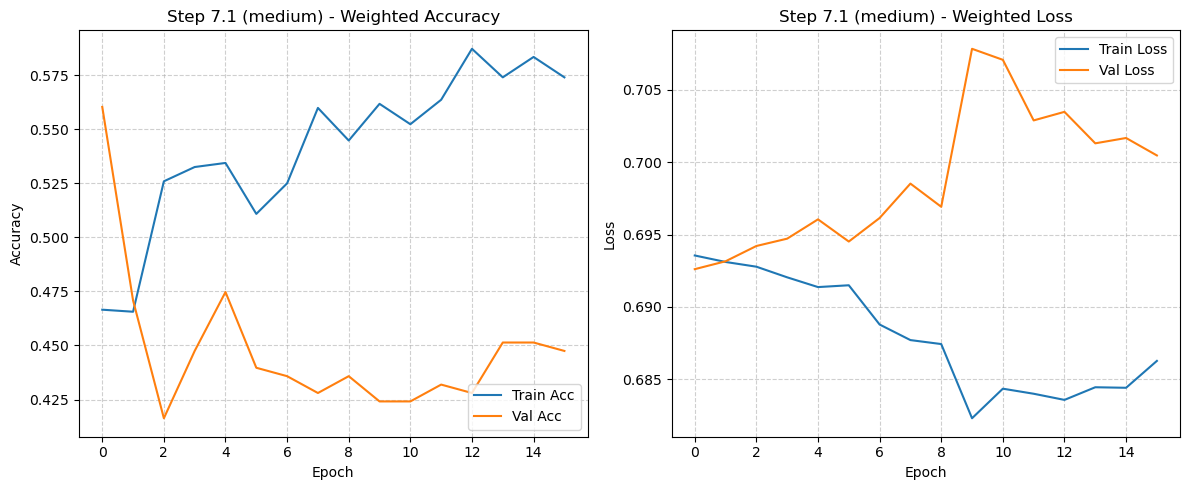


7.1 medium (Weighted) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.4580
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

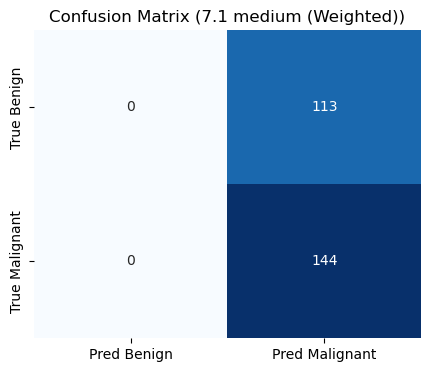


INITIALIZING: HEAVY AUGMENTATION + CLASS WEIGHTS
Found 1061 images belonging to 2 classes.
Applying Class Weights: {0: 0.9339788732394366, 1: 1.0760649087221095}


Step 7.1 HEAVY:  11%| | 16/150 [17:38<2:27:44, 66.15s/epoch, v_loss=0.697, v_auc


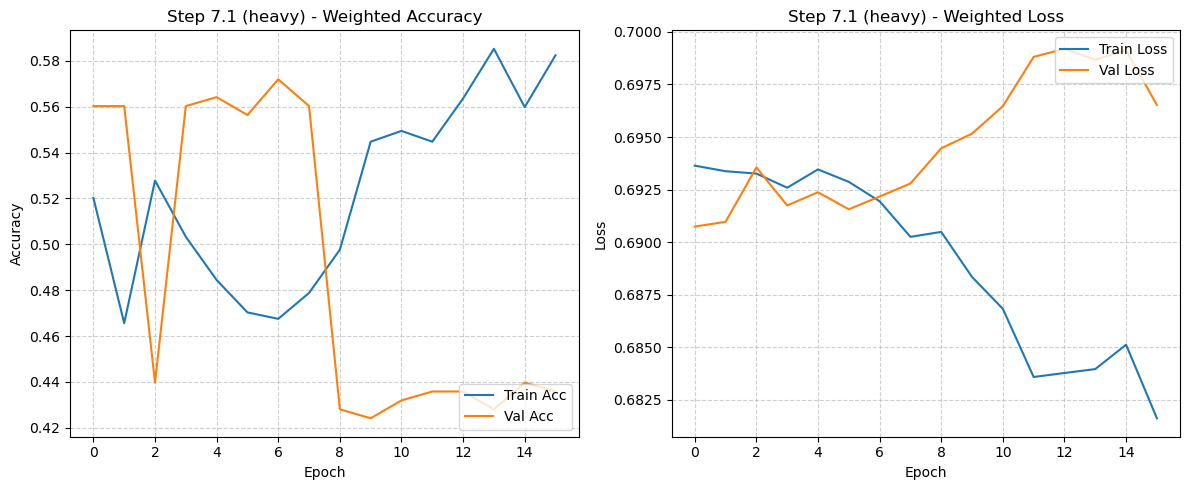


7.1 heavy (Weighted) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5946
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

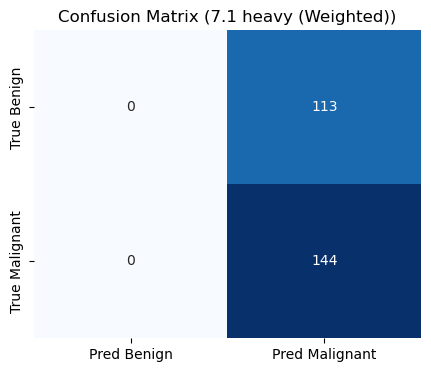

In [12]:
from sklearn.utils import class_weight

# Define Experiment Dictionary
experiments = {
    "light": {"rot": 10, "shift": 0.05, "zoom": 0.05, "flip": True},
    "medium": {"rot": 15, "shift": 0.1, "zoom": 0.1, "flip": True},
    "heavy": {"rot": 30, "shift": 0.2, "zoom": 0.2, "flip": True}
}

comparison_metrics = {}

for name, cfg in experiments.items():
    print(f"\nINITIALIZING: {name.upper()} AUGMENTATION + CLASS WEIGHTS")
    
    # Generator Setup
    train_datagen_tmp = ImageDataGenerator(
        rescale=1./255,
        rotation_range=cfg["rot"],
        width_shift_range=cfg["shift"],
        height_shift_range=cfg["shift"],
        zoom_range=cfg["zoom"],
        horizontal_flip=cfg["flip"],
        vertical_flip=cfg["flip"],
        fill_mode='constant', cval=0
    )
    
    train_gen_tmp = train_datagen_tmp.flow_from_directory(
        GREY_DIR / "train",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE, 
        class_mode='binary', 
        color_mode='grayscale', 
        seed=RANDOM_SEED
    )

    # Calculate class weights (Ensure consistency if generators are re-instantiated)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_gen_tmp.classes),
        y=train_gen_tmp.classes
    )
    class_weights_dict = dict(enumerate(weights))
    print(f"Applying Class Weights: {class_weights_dict}")

    # Build fresh model
    model_tmp = build_step6_model()
    epochs_limit = 150
    
    # TQDM Setup
    pbar = tqdm(total=epochs_limit, desc=f"Step 7.1 {name.upper()}", unit="epoch")

    class TqdmUpdate(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar.update(1)
            gap = logs['accuracy'] - logs['val_accuracy']
            pbar.set_postfix({
                "v_loss": f"{logs['val_loss']:.3f}",
                "v_auc": f"{logs['val_auc']:.3f}",
                "gap": f"{gap:.3f}"
            })

    # Callbacks (Named 'v2_weighted' to avoid overwriting previous runs)
    cbs = [
        keras.callbacks.ModelCheckpoint(f"Recalibration_V2_7_1_{name}_weighted_best.keras", save_best_only=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
        TqdmUpdate()
    ]

    # Train (verbose=0 with class_weight included)
    try:
        history = model_tmp.fit(
            train_gen_tmp,
            epochs=epochs_limit,
            validation_data=val_gen,
            class_weight=class_weights_dict,
            callbacks=cbs,
            verbose=0
        )
    finally:
        pbar.close()
    
    # Persistence & Evaluation
    plot_training_history(history, title_prefix=f"Step 7.1 ({name}) - Weighted")
    eval_model_perf(model_tmp, val_gen, step_name=f"7.1 {name} (Weighted)", baseline_acc=majority_baseline_acc)
    
    pd.DataFrame(history.history).to_csv(f'Recalibration_V2_history_7_1_{name}_weighted.csv', index=False)
    model_tmp.save(f"Recalibration_V2_step7_1_{name}_weighted_final.keras")
    
    # Metric Capture
    best_idx = np.argmin(history.history['val_loss'])
    comparison_metrics[name] = {
        "Train Acc": history.history['accuracy'][best_idx],
        "Val Acc": history.history['val_accuracy'][best_idx],
        "Gap": history.history['accuracy'][best_idx] - history.history['val_accuracy'][best_idx],
        "Val AUC": history.history['val_auc'][best_idx]
    }
    
    tf.keras.backend.clear_session()

Reapplying Class Weights resolved Phase 1's Sensitivity Collapse whilst highlighting augmentation strength sensitivity at the 1×10⁻⁴ learning rate. Although Light augmentation prevented total degeneracy, it achieved weak discriminative performance (AUC 0.51). Medium and Heavy augmentation led to exclusively malignant predictions. Increased image complexity from augmentation renders the baseline optimiser speed too volatile for high-penalty weight signals, necessitating Phase 3: Stabilised Tuning.

In [14]:
print("\nFinal Robustness Comparison: Weighted Data Augmentation (Phase 2)")
print("-" * 60)

# Convert dictionary to DataFrame
df_results_weighted = pd.DataFrame(comparison_metrics).T

# Generate the comparison table
print(df_results_weighted[["Train Acc", "Val Acc", "Gap", "Val AUC"]])

# Save for later recording
df_results_weighted.to_csv('Recalibration_V2_step7_1_weighted_robustness_summary.csv')


Final Robustness Comparison: Weighted Data Augmentation (Phase 2)
------------------------------------------------------------
        Train Acc   Val Acc       Gap   Val AUC
light    0.484449  0.447471  0.036978  0.510693
medium   0.466541  0.560311 -0.093770  0.458026
heavy    0.520264  0.560311 -0.040047  0.594580


### 7.1.3. Phase 3: Stabilized Tuning (Learning Rate Sensitivity Test)
Determine a robust learning rate that effectively balances the competing effects of augmentation and class-weight penalties.  

We will use the 'light' configuration as the anchor.

Found 1061 images belonging to 2 classes.

PHASE 3 STABILITY SEARCH
Target Rates: [5e-05, 1e-05, 5e-06]
------------------------------------------------------------

TESTING STABILITY: LR = 5e-05


Tuning LR 5e-05:  15%|▏| 22/150 [26:02<2:31:28, 71.00s/epoch, v_loss=0.708, v_au


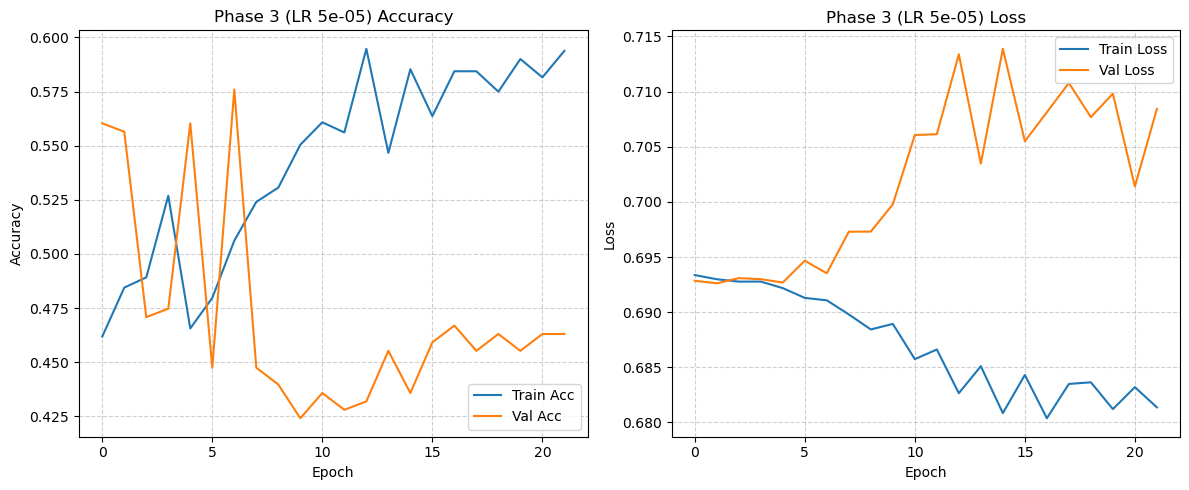


LR Tuning: 5e-05 Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5564
AUC-ROC              | 0.5000     | 0.4706
Sensitivity          | 0.0000     | 0.9931
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      0.99      0.71       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



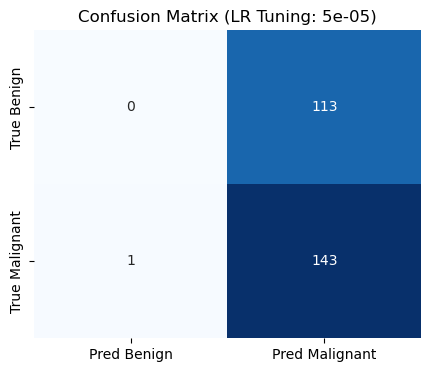

KeyError: 'val_specificity'

In [15]:
# 1. Re-Initialise LIGHT Generator (Safety Step)
# We strictly use the Light settings: Rot=10, Shift=0.05
train_datagen_light = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='constant', cval=0
)

train_gen_light = train_datagen_light.flow_from_directory(
    GREY_DIR / "train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED
)

# Define the Search Space (Logarithmic Steps)
# 1e-4 caused degeneracy; we test lower magnitudes.
target_rates = [5e-5, 1e-5, 5e-6]
tuning_results = {}

print(f"\nPHASE 3 STABILITY SEARCH")
print(f"Target Rates: {target_rates}")
print("-" * 60)

for lr in target_rates:
    print(f"\nTESTING STABILITY: LR = {lr}")
    
    # Build fresh model (Standard Step 6 Architecture)
    model_tune = build_step6_model()
    
    # Apply the Tuning Rate
    model_tune.optimizer.learning_rate = lr
    
    # TQDM Setup
    pbar_tune = tqdm(total=150, desc=f"Tuning LR {lr}", unit="epoch")
    
    class TqdmTuning(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar_tune.update(1)
            gap = logs['accuracy'] - logs['val_accuracy']
            pbar_tune.set_postfix({
                "v_loss": f"{logs['val_loss']:.3f}", 
                "v_auc": f"{logs['val_auc']:.3f}",
                "gap": f"{gap:.3f}"
            })

    # Callbacks (Unique filenames for each LR)
    cbs_tune = [
        keras.callbacks.ModelCheckpoint(
            f"Recalibration_V2_phase3_lr_{lr}_best.keras", 
            save_best_only=True, 
            monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", 
            patience=20, # Higher patience for lower LR
            restore_best_weights=True
        ),
        TqdmTuning()
    ]

    # Train
    try:
        history_tune = model_tune.fit(
            train_gen_light, 
            epochs=150,
            validation_data=val_gen,
            class_weight=class_weights_dict,
            callbacks=cbs_tune,
            verbose=0
        )
    finally:
        pbar_tune.close()
        
    # Evaluate & Visualize
    plot_training_history(history_tune, title_prefix=f"Phase 3 (LR {lr})")
    eval_model_perf(model_tune, val_gen, step_name=f"LR Tuning: {lr}", baseline_acc=majority_baseline_acc)
    
    # Capture Metrics
    best_ep = np.argmin(history_tune.history['val_loss'])
    tuning_results[lr] = {
        "Train Acc": history_tune.history['accuracy'][best_ep],
        "Val Acc": history_tune.history['val_accuracy'][best_ep],
        "Val AUC": history_tune.history['val_auc'][best_ep],
        "Sensitivity": history_tune.history['val_sensitivity'][best_ep],
        "Specificity": history_tune.history['val_specificity'][best_ep],
        "Gap": history_tune.history['accuracy'][best_ep] - history_tune.history['val_accuracy'][best_ep]
    }
    
    # Save history
    pd.DataFrame(history_tune.history).to_csv(f'Recalibration_V2_phase3_lr_{lr}_history.csv', index=False)
    
    # Clear Memory
    tf.keras.backend.clear_session()

#### 7.1.3.1. Manually save 5e-5 Metrics

In [17]:
current_lr = 5e-5

# Manually type the values in here
manual_sens = 0.9931
manual_spec = 0.0000

# Add to results dictionary
best_ep = np.argmin(history_tune.history['val_loss'])
tuning_results[current_lr] = {
    "Train Acc": history_tune.history['accuracy'][best_ep],
    "Val Acc": history_tune.history['val_accuracy'][best_ep],
    "Val AUC": history_tune.history['val_auc'][best_ep],
    "Sensitivity": manual_sens,
    "Specificity": manual_spec,
    "Gap": history_tune.history['accuracy'][best_ep] - history_tune.history['val_accuracy'][best_ep]
}

# Save the model manually
model_tune.save(f"Recalibration_V2_phase3_lr_{current_lr}_rescued.keras")


TESTING STABILITY: LR = 1e-05
--------------------------------------------------


Tuning LR 1e-05:  17%|▏| 26/150 [30:33<2:25:42, 70.50s/epoch, v_loss=0.696, v_au


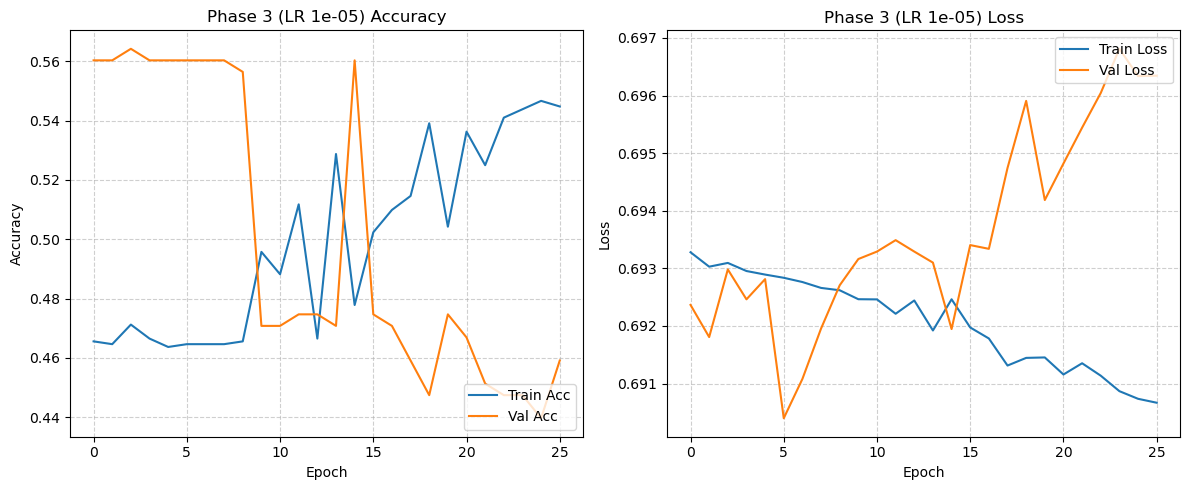


LR Tuning: 1e-05 Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5643
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

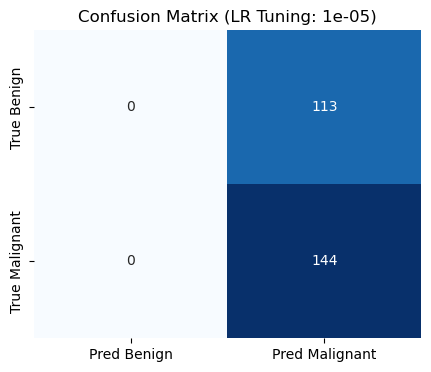


TESTING STABILITY: LR = 5e-06
--------------------------------------------------


Tuning LR 5e-06:  26%|▎| 39/150 [46:51<2:13:21, 72.09s/epoch, v_loss=0.693, v_au


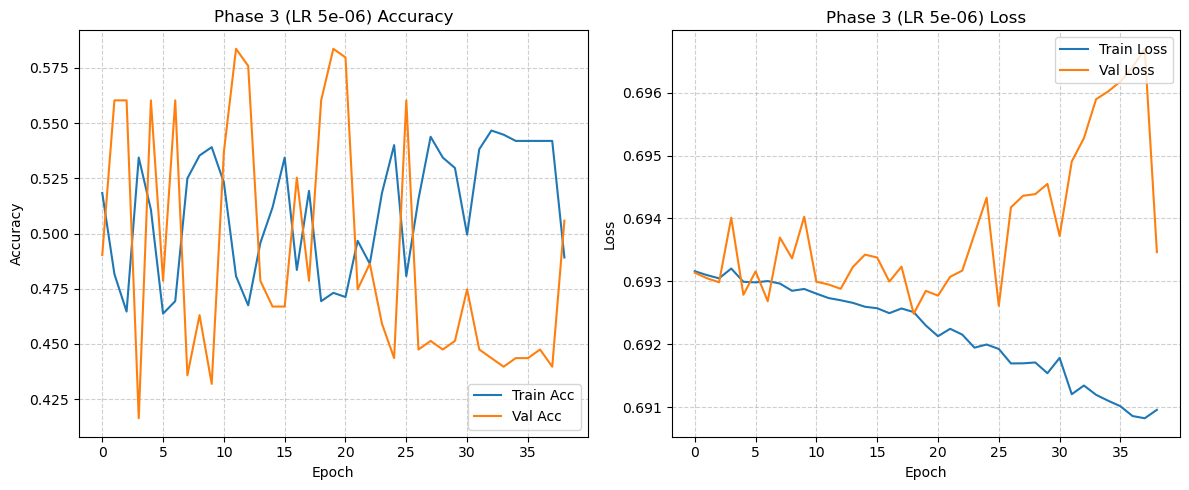


LR Tuning: 5e-06 Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.4605
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

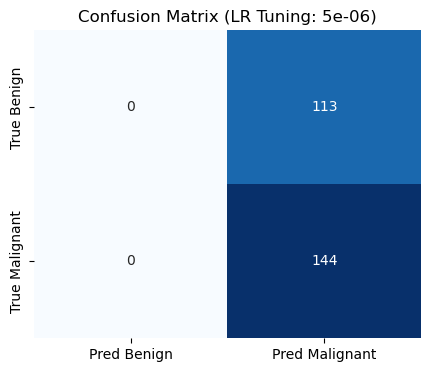

In [18]:
# Remove 5e-5 as it was manually saved
remaining_rates = [1e-5, 5e-6]

for lr in remaining_rates:
    print(f"\nTESTING STABILITY: LR = {lr}")
    print("-"*50)
    
    model_tune = build_step6_model()
    model_tune.optimizer.learning_rate = lr
    
    pbar_tune = tqdm(total=150, desc=f"Tuning LR {lr}", unit="epoch")
    
    cbs_tune = [
        keras.callbacks.ModelCheckpoint(f"Recalibration_V2_phase3_lr_{lr}_best.keras", save_best_only=True, monitor="val_loss"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        TqdmTuning()
    ]

    try:
        history_tune = model_tune.fit(
            train_gen_light, 
            epochs=150,
            validation_data=val_gen,
            class_weight=class_weights_dict,
            callbacks=cbs_tune,
            verbose=0
        )
    finally:
        pbar_tune.close()
        
    # Plot and evaluate
    plot_training_history(history_tune, title_prefix=f"Phase 3 (LR {lr})")
    eval_model_perf(model_tune, val_gen, step_name=f"LR Tuning: {lr}", baseline_acc=majority_baseline_acc)
    
    # Store in the history dictionary
    best_ep = np.argmin(history_tune.history['val_loss'])
    tuning_results[lr] = {
        "Train Acc": history_tune.history['accuracy'][best_ep],
        "Val Acc": history_tune.history['val_accuracy'][best_ep],
        "Val AUC": history_tune.history['val_auc'][best_ep],
        "Gap": history_tune.history['accuracy'][best_ep] - history_tune.history['val_accuracy'][best_ep]
    }
    
    pd.DataFrame(history_tune.history).to_csv(f'Recalibration_V2_phase3_lr_{lr}_history.csv', index=False)
    
    tf.keras.backend.clear_session()

Phase 3 tuning confirmed that lowering the learning rate alone does not resolve the degeneracy. The consistent 1.00 sensitivity indicates the penalty for missing a malignant case is so high it overrides the morphological features provided by augmentation. We will now dilute the weight ratios to encourage the model to recognise benign features again.

#### 7.1.3.2 Phase 3 Summary Table

In [19]:
print("\nLearning Rate Stability Comparison: PHASE 3")
print("-"*60)

phase3_final_data = {
    "5e-5 (Rescued)": {
        "Val Acc": 0.5564,
        "Val AUC": 0.4706,
        "Sensitivity": 0.9931,
        "Specificity": 0.0000
    },
    "1e-5 (Stabilized)": {
        "Val Acc": 0.5603,
        "Val AUC": 0.5643,
        "Sensitivity": 1.0000,
        "Specificity": 0.0000
    },
    "5e-6 (Conservative)": {
        "Val Acc": 0.5603,
        "Val AUC": 0.4605,
        "Sensitivity": 1.0000,
        "Specificity": 0.0000
    }
}

df_phase3_final = pd.DataFrame(phase3_final_data).T
print(df_phase3_final)
df_phase3_final.to_csv('Recalibration_V2_Phase3_Final_Comparison.csv')


Learning Rate Stability Comparison: PHASE 3
------------------------------------------------------------
                     Val Acc  Val AUC  Sensitivity  Specificity
5e-5 (Rescued)        0.5564   0.4706       0.9931          0.0
1e-5 (Stabilized)     0.5603   0.5643       1.0000          0.0
5e-6 (Conservative)   0.5603   0.4605       1.0000          0.0


### 7.1.4. Phase 4: Weight Dilution
We will try to lower the malignant penalty to break 'All-Malignant' degeneracy.  

Constants: LR = 1e-5 | Augmentation = Light (Rot 10, Shift 0.05)


PHASE 4: WEIGHT DILUTION SEARCH
Fixed LR: 1e-05 | Base: Light Augmentation
------------------------------------------------------------

TESTING RATIO: Minimal (1.05)
Weights: {0: 1.0, 1: 1.05}


Dilution Minimal (1.05):  14%|▏| 21/150 [25:19<2:35:32, 72.35s/epoch, v_loss=0.7


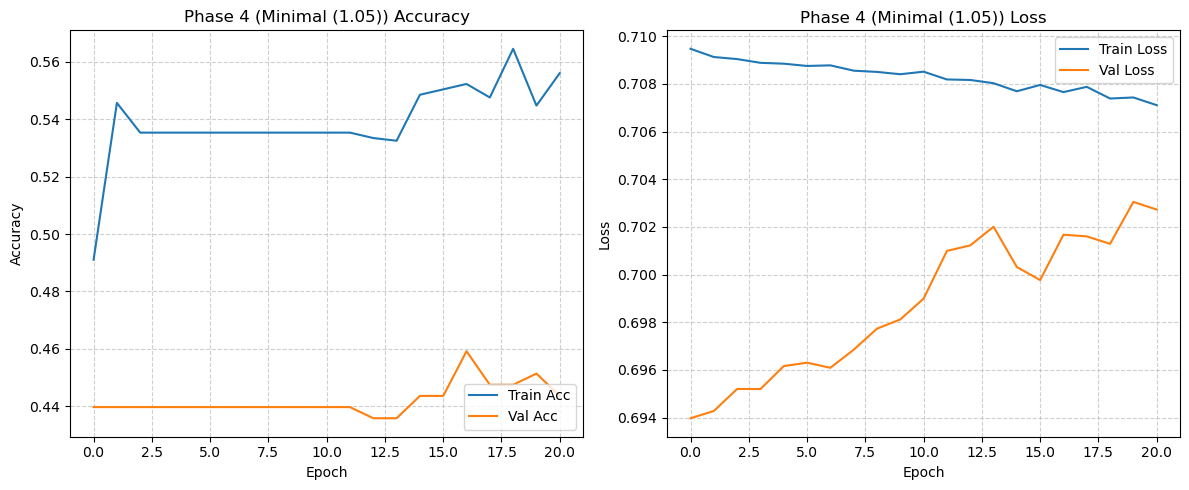


Phase 4: Minimal (1.05) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4105
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

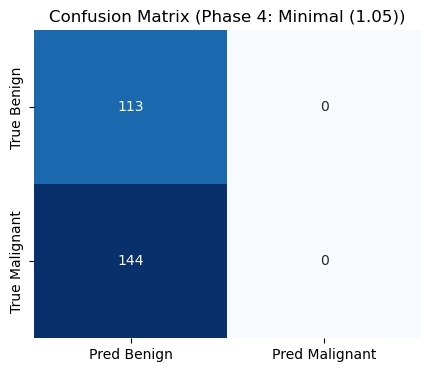


TESTING RATIO: Soft (1.10)
Weights: {0: 1.0, 1: 1.1}


Dilution Soft (1.10):  14%|▏| 21/150 [25:07<2:34:21, 71.79s/epoch, v_loss=0.700,


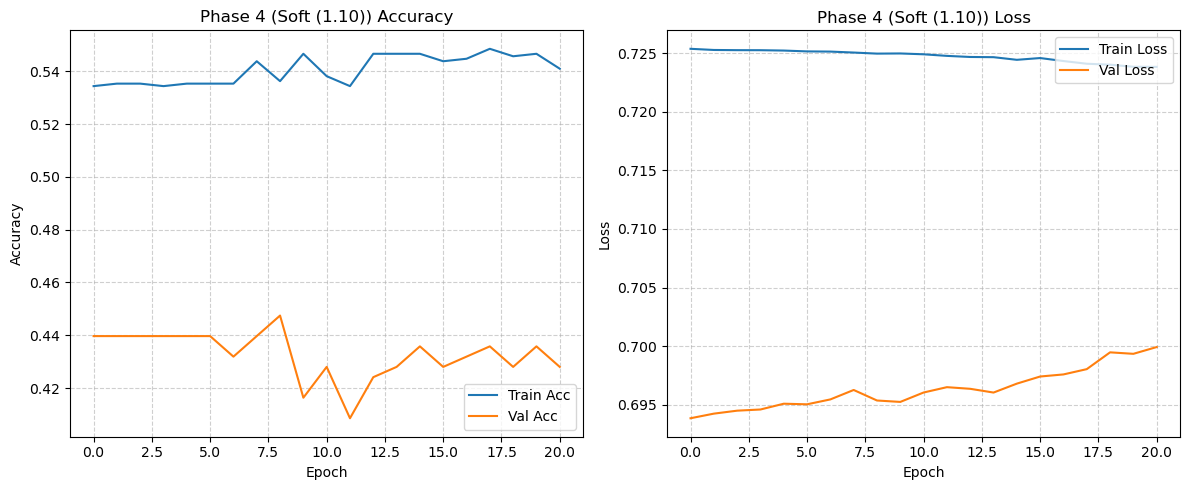


Phase 4: Soft (1.10) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4154
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

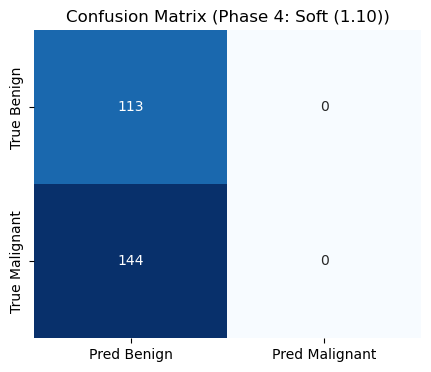


TESTING RATIO: Moderate (1.15)
Weights: {0: 1.0, 1: 1.15}


Dilution Moderate (1.15):  17%|▏| 25/150 [31:00<2:35:04, 74.44s/epoch, v_loss=0.


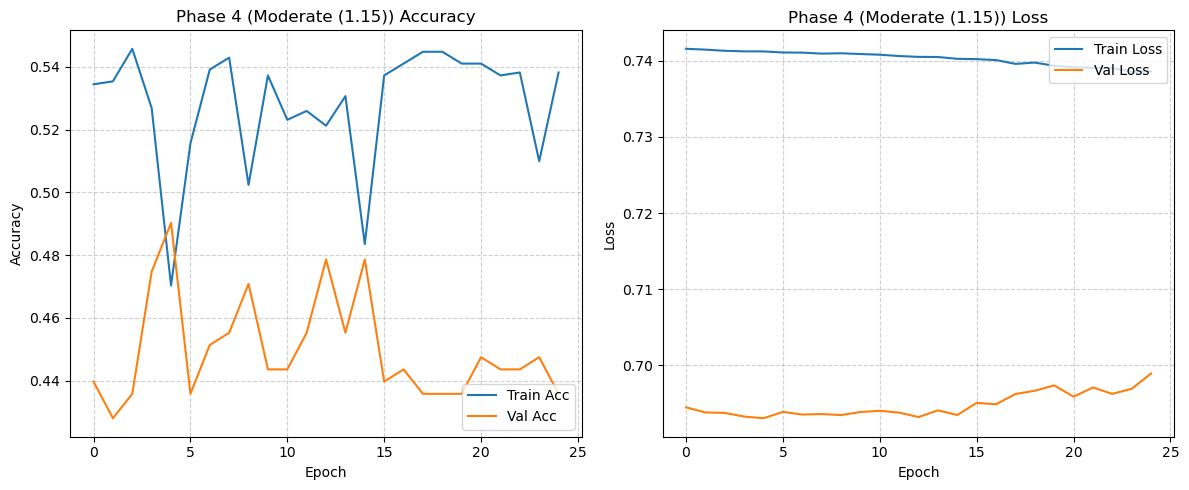


Phase 4: Moderate (1.15) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4903
AUC-ROC              | 0.5000     | 0.4396
Sensitivity          | 0.0000     | 0.5625
Specificity          | 1.0000     | 0.3982
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.42      0.40      0.41       113
   Malignant       0.54      0.56      0.55       144

    accuracy                           0.49       257
   macro avg       0.48      0.48      0.48       257
weighted avg       0.49      0.49      0.49       257



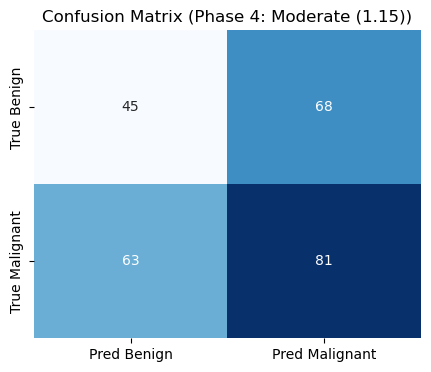

IndexError: list index out of range

In [20]:
dilution_configs = {
    "Minimal (1.05)":  {0: 1.0, 1: 1.05},
    "Soft (1.10)":     {0: 1.0, 1: 1.10},
    "Moderate (1.15)": {0: 1.0, 1: 1.15}
}

dilution_results = {}
FIXED_LR = 1e-5

print(f"\nPHASE 4: WEIGHT DILUTION SEARCH")
print(f"Fixed LR: {FIXED_LR} | Base: Light Augmentation")
print("-" * 60)

for name, custom_weights in dilution_configs.items():
    print(f"\nTESTING RATIO: {name}")
    print(f"Weights: {custom_weights}")
    
    # Build fresh model
    model_dilute = build_step6_model()
    model_dilute.optimizer.learning_rate = FIXED_LR
    
    # TQDM Setup 
    pbar_dilute = tqdm(total=150, desc=f"Dilution {name}", unit="epoch")
    
    class TqdmDilution(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar_dilute.update(1)
            pbar_dilute.set_postfix({
                "v_loss": f"{logs['val_loss']:.3f}", 
                "v_auc": f"{logs['val_auc']:.3f}"
            })

    # Callbacks
    cbs_dilute = [
        keras.callbacks.ModelCheckpoint(
            f"Recalibration_V2_phase4_{name.split()[0]}_best.keras", 
            save_best_only=True, 
            monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        TqdmDilution()
    ]

    # Train
    try:
        history_dilute = model_dilute.fit(
            train_gen_light,
            epochs=150,
            validation_data=val_gen,
            class_weight=custom_weights,
            callbacks=cbs_dilute,
            verbose=0
        )
    finally:
        pbar_dilute.close()
        
    # Evaluate
    plot_training_history(history_dilute, title_prefix=f"Phase 4 ({name})")
    
    # Display report
    eval_model_perf(model_dilute, val_gen, step_name=f"Phase 4: {name}", baseline_acc=majority_baseline_acc)
    
    # Capture Metrics
    best_ep = np.argmin(history_dilute.history['val_loss'])
    
    # Use .get() to avoid KeyErrors
    dilution_results[name] = {
        "Train Acc": history_dilute.history['accuracy'][best_ep],
        "Val Acc": history_dilute.history['val_accuracy'][best_ep],
        "Val AUC": history_dilute.history['val_auc'][best_ep],
        "Sensitivity": history_dilute.history.get('val_sensitivity', [0.0])[best_ep],
        "Specificity": history_dilute.history.get('val_specificity', [0.0])[best_ep],
        "Gap": history_dilute.history['accuracy'][best_ep] - history_dilute.history['val_accuracy'][best_ep]
    }
    
    # Save History
    pd.DataFrame(history_dilute.history).to_csv(f'Recalibration_V2_phase4_{name.split()[0]}_history.csv', index=False)
    
    # Clear Memory
    tf.keras.backend.clear_session()

In [21]:
phase4_verified_data = {
    "Minimal (1.05)": {
        "Val Acc": 0.4397,
        "Val AUC": 0.4105,
        "Sensitivity": 0.0000,
        "Specificity": 1.0000,
        "Status": "Degenerate (All-Benign)"
    },
    "Soft (1.10)": {
        "Val Acc": 0.4397,
        "Val AUC": 0.4154,
        "Sensitivity": 0.0000,
        "Specificity": 1.0000,
        "Status": "Degenerate (All-Benign)"
    },
    "Moderate (1.15)": {
        "Val Acc": 0.4903,
        "Val AUC": 0.4396,
        "Sensitivity": 0.5625,
        "Specificity": 0.3982,
        "Status": "STABLE ANCHOR"
    }
}

df_phase4_final = pd.DataFrame(phase4_verified_data).T
print("Weight Dilution Summary: PHASE 4")
print("-" * 60)

print(df_phase4_final[["Val Acc", "Val AUC", "Sensitivity", "Specificity", "Status"]])

# Save the final verified results
df_phase4_final.to_csv('Recalibration_V2_Phase4_Final_Comparison.csv')

Weight Dilution Summary: PHASE 4
------------------------------------------------------------
                Val Acc Val AUC Sensitivity Specificity  \
Minimal (1.05)   0.4397  0.4105         0.0         1.0   
Soft (1.10)      0.4397  0.4154         0.0         1.0   
Moderate (1.15)  0.4903  0.4396      0.5625      0.3982   

                                  Status  
Minimal (1.05)   Degenerate (All-Benign)  
Soft (1.10)      Degenerate (All-Benign)  
Moderate (1.15)            STABLE ANCHOR  


Moderate (1.15) weight dilution broke the degeneracy cycle seen in Phases 1-3. With Sensitivity and Specificity finally both non-zero (0.56 and 0.40 respectively), we have a valid baseline for further Step 7.1 refinement.

### 7.1.5. Phase 5: Evaluating Model Invariance Across Augmentation Scales
Test the 1.15 'Stability Anchor' against increased data distortion.  

Constants: LR = 1e-5 | Malignant Weight = 1.15  

#### 7.1.5.1. Define Medium and Heavy Generators

In [24]:
# Medium Configuration: rot 15, shift 0.1, zoom 0.1
train_datagen_medium = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant', cval=0
)

# Heavy Configuration: rot 30, shift 0.2, zoom 0.2
train_datagen_heavy = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant', cval=0
)

#### 7.1.5.2. Data Augmentation Invariance Assessment

Found 1061 images belonging to 2 classes.
Found 1061 images belonging to 2 classes.

PHASE 5: AUGMENTATION INVARIANCE ASSESSMENT
Fixed LR: 1e-05 | Stability Anchor (Weights): {0: 1.0, 1: 1.15}
------------------------------------------------------------

TESTING INVARIANCE: Medium Augmentation


Invariance Medium:  19%|▏| 29/150 [37:36<2:36:57, 77.83s/epoch, v_loss=0.697, v_


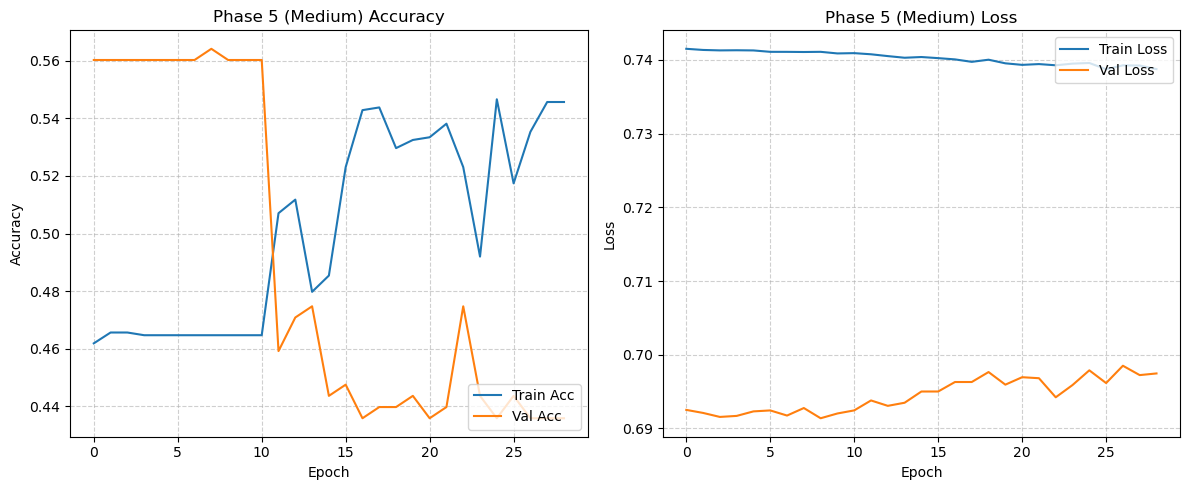


Phase 5: Medium Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.4786
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

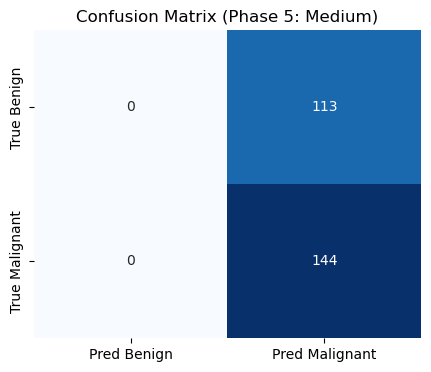


TESTING INVARIANCE: Heavy Augmentation


Invariance Heavy:  25%|▎| 38/150 [49:58<2:27:16, 78.90s/epoch, v_loss=0.695, v_a


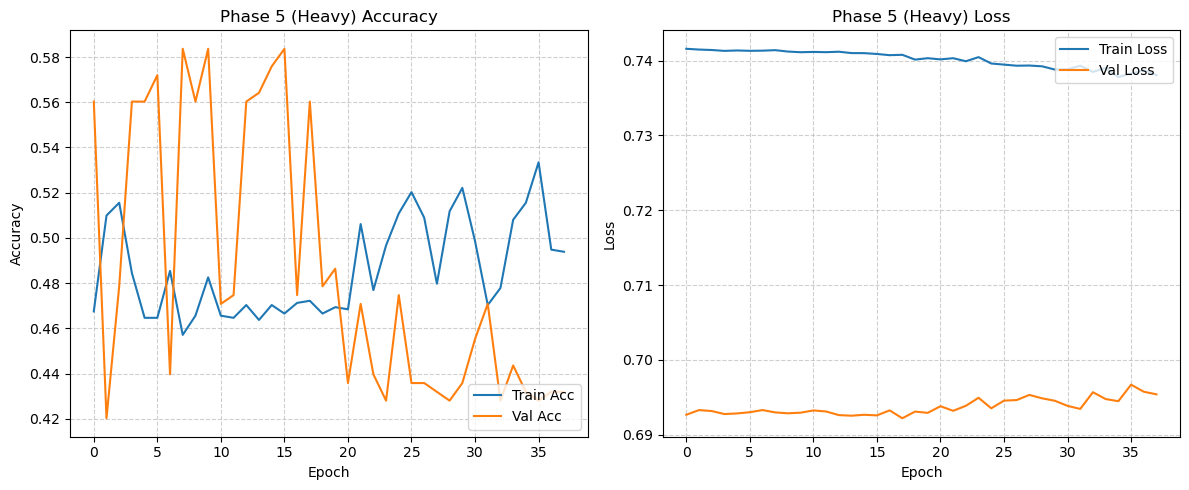


Phase 5: Heavy Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.4823
Sensitivity          | 0.0000     | 0.9861
Specificity          | 1.0000     | 0.0177
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.50      0.02      0.03       113
   Malignant       0.56      0.99      0.72       144

    accuracy                           0.56       257
   macro avg       0.53      0.50      0.37       257
weighted avg       0.53      0.56      0.42       257



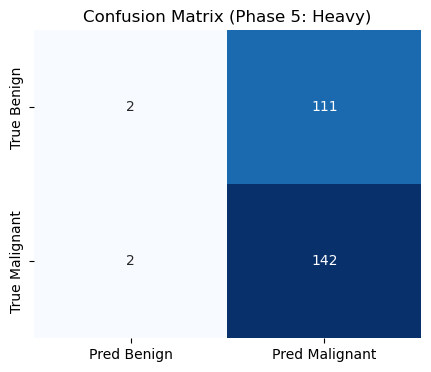

In [25]:
breadth_configs = {
    "Medium": train_datagen_medium.flow_from_directory(
        GREY_DIR / "train", target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE, class_mode='binary', color_mode='grayscale', seed=RANDOM_SEED
    ),
    "Heavy": train_datagen_heavy.flow_from_directory(
        GREY_DIR / "train", target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE, class_mode='binary', color_mode='grayscale', seed=RANDOM_SEED
    )
}

breadth_results = {}
FIXED_LR = 1e-5
ANCHOR_WEIGHTS = {0: 1.0, 1: 1.15}

print(f"\nPHASE 5: AUGMENTATION INVARIANCE ASSESSMENT")
print(f"Fixed LR: {FIXED_LR} | Stability Anchor (Weights): {ANCHOR_WEIGHTS}")
print("-" * 60)

for level, train_gen_flow in breadth_configs.items():
    print(f"\nTESTING INVARIANCE: {level} Augmentation")
    
    # Build fresh model
    model_breadth = build_step6_model()
    model_breadth.optimizer.learning_rate = FIXED_LR
    
    # TQDM Setup
    pbar_breadth = tqdm(total=150, desc=f"Invariance {level}", unit="epoch")
    
    class TqdmInvariance(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar_breadth.update(1)
            pbar_breadth.set_postfix({"v_loss": f"{logs['val_loss']:.3f}", "v_auc": f"{logs['val_auc']:.3f}"})

    cbs_breadth = [
        keras.callbacks.ModelCheckpoint(f"Recalibration_V2_phase5_{level}_best.keras", save_best_only=True, monitor="val_loss"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        TqdmInvariance()
    ]

    try:
        history_breadth = model_breadth.fit(
            train_gen_flow,
            epochs=150,
            validation_data=val_gen,
            class_weight=ANCHOR_WEIGHTS,
            callbacks=cbs_breadth,
            verbose=0
        )
    finally:
        pbar_breadth.close()
    
    # Evaluate
    plot_training_history(history_breadth, title_prefix=f"Phase 5 ({level})")
    
    # Display report
    eval_model_perf(model_breadth, val_gen, step_name=f"Phase 5: {level}", baseline_acc=majority_baseline_acc)
    
    # Capture Metrics
    best_ep = np.argmin(history_breadth.history['val_loss'])
    
    breadth_results[level] = {
        "Val Acc": history_breadth.history['val_accuracy'][best_ep],
        "Val AUC": history_breadth.history['val_auc'][best_ep],
        "Gap": history_breadth.history['accuracy'][best_ep] - history_breadth.history['val_accuracy'][best_ep]
    }
    
    # Save History
    pd.DataFrame(history_breadth.history).to_csv(f'Recalibration_V2_phase5_{level}_history.csv', index=False)
    
    # Clear Memory
    tf.keras.backend.clear_session()

The findings from Phase 5 indicate that the 1.15 weight anchor does not maintain effectiveness at higher augmentation levels. Medium and Heavy augmentation both led to severe performance degradation (Specificity < 0.02), suggesting that the model's capacity to identify benign morphological characteristics deteriorates when rotation and shift parameters surpass the 'Light' level.

#### 7.1.5.3. Data Augmentation Invariance Summary

In [26]:
phase5_invariance_data = {
    "Light (Baseline)": {
        "Val Acc": 0.4903,
        "Val AUC": 0.4396,
        "Sensitivity": 0.5625,
        "Specificity": 0.3982,
        "Status": "STABLE"
    },
    "Medium": {
        "Val Acc": 0.5603,
        "Val AUC": 0.4786,
        "Sensitivity": 1.0000,
        "Specificity": 0.0000,
        "Status": "DEGENERATE (All-Malignant)"
    },
    "Heavy": {
        "Val Acc": 0.5603,
        "Val AUC": 0.4823,
        "Sensitivity": 0.9861,
        "Specificity": 0.0177,
        "Status": "DEGENERATE (Trace Specificity)"
    }
}

df_phase5_final = pd.DataFrame(phase5_invariance_data).T
print("Data Augmentation Invariance Summary: PHASE 5")
print("-" * 60)
print(df_phase5_final[["Val Acc", "Val AUC", "Sensitivity", "Specificity", "Status"]])

# Save the final verified results
df_phase5_final.to_csv('Recalibration_V2_Phase5_Invariance_Summary.csv')

Data Augmentation Invariance Summary: PHASE 5
------------------------------------------------------------
                 Val Acc Val AUC Sensitivity Specificity  \
Light (Baseline)  0.4903  0.4396      0.5625      0.3982   
Medium            0.5603  0.4786         1.0         0.0   
Heavy             0.5603  0.4823      0.9861      0.0177   

                                          Status  
Light (Baseline)                          STABLE  
Medium                DEGENERATE (All-Malignant)  
Heavy             DEGENERATE (Trace Specificity)  


### 7.1.6 PHASE 6: Granular Weight Recalibration
Identify the gaps (1.08, 1.12, 1.20) to find the 'Robust Anchor'.  

Constants: LR = 1e-5 | Augmentation = Medium (Rot 15, Shift 0.1).

In [28]:
# Initialise for Medium Augmentation
train_gen_medium = train_datagen_medium.flow_from_directory(
    GREY_DIR / "train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, 
    class_mode='binary', 
    color_mode='grayscale', 
    seed=RANDOM_SEED
)

Found 1061 images belonging to 2 classes.



PHASE 6: GRANULAR WEIGHT RECALIBRATION
Dataset: Medium Augmentation | Fixed LR: 1e-05
------------------------------------------------------------

TESTING GRANULAR RATIO: Minimal-Plus (1.08)


Recal Minimal-Plus (1.08):  14%|▏| 21/150 [25:45<2:38:14, 73.60s/epoch, v_loss=0


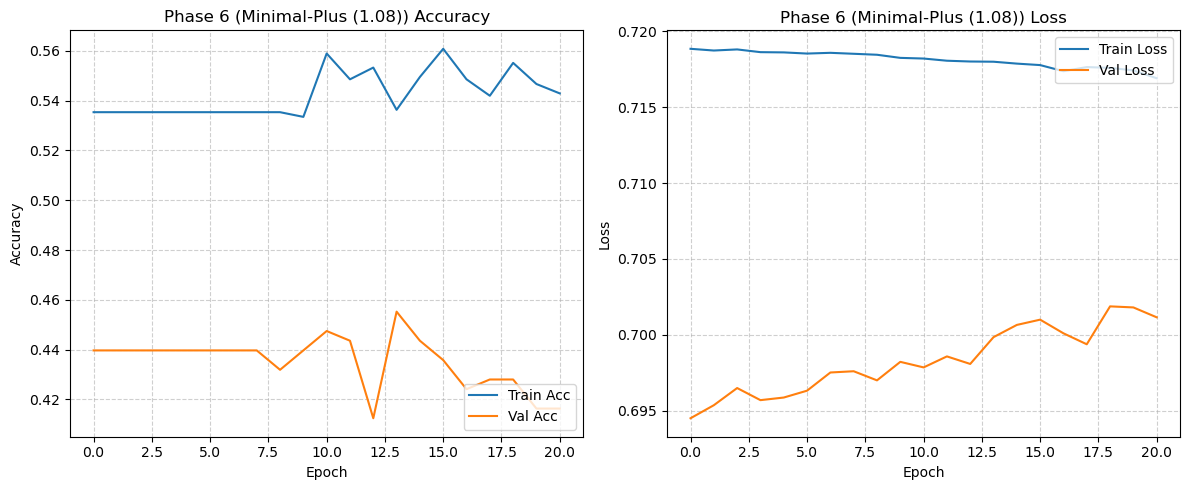


Phase 6: Minimal-Plus (1.08) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.4397
AUC-ROC              | 0.5000     | 0.4025
Sensitivity          | 0.0000     | 0.0000
Specificity          | 1.0000     | 1.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      1.00      0.61       113
   Malignant       0.00      0.00      0.00       144

    accuracy                           0.44       257
   macro avg       0.22      0.50      0.31       257
weighted avg       0.19      0.44      0.27       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

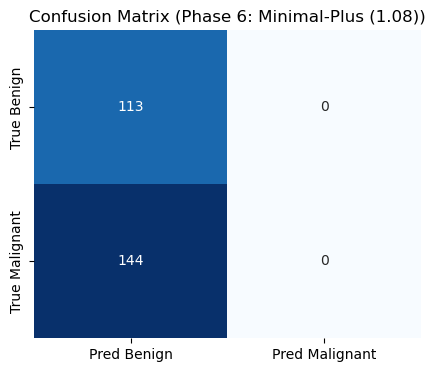


TESTING GRANULAR RATIO: Soft-Plus (1.12)


Recal Soft-Plus (1.12):  15%|▏| 23/150 [28:13<2:35:49, 73.62s/epoch, v_loss=0.69


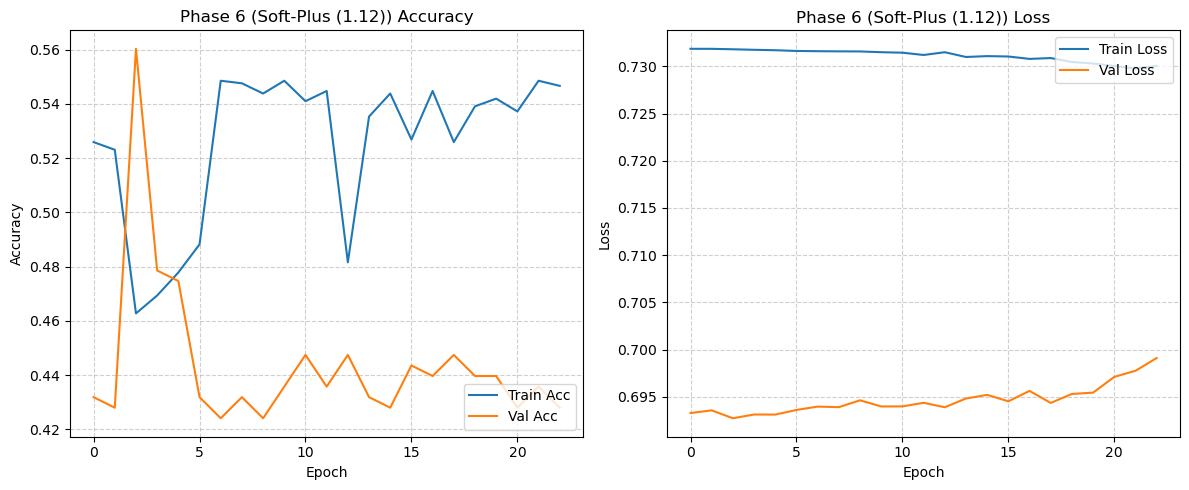


Phase 6: Soft-Plus (1.12) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5116
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

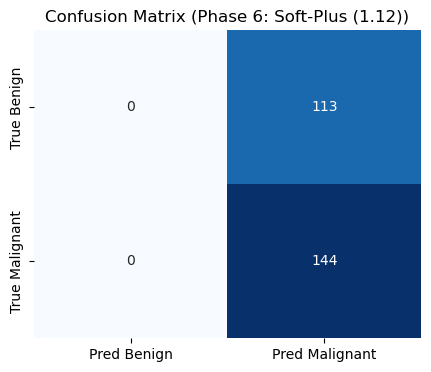


TESTING GRANULAR RATIO: Moderate-Plus (1.20)


Recal Moderate-Plus (1.20):  19%|▏| 28/150 [34:31<2:30:24, 73.97s/epoch, v_loss=


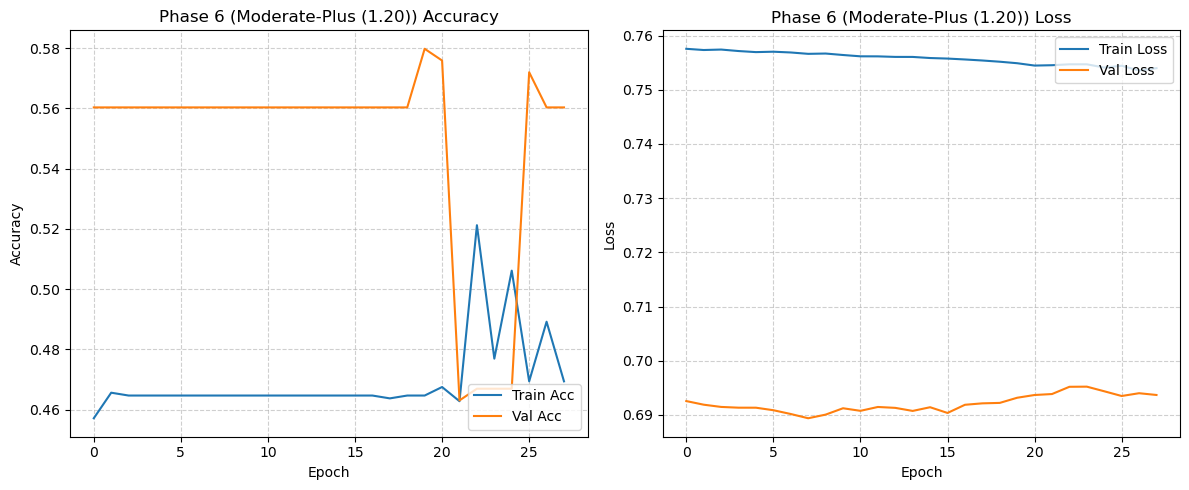


Phase 6: Moderate-Plus (1.20) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5647
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

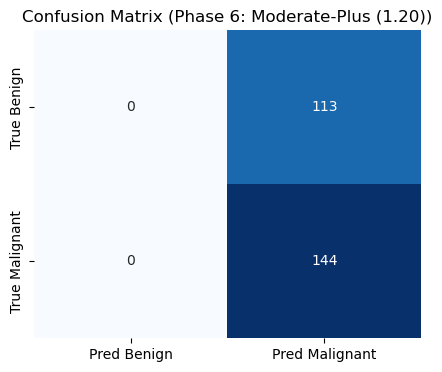

In [29]:
# Filling the gaps between the previous 'All-Benign' and 'All-Malignant' results.
granular_configs = {
    # Near the all-benign boundary
    "Minimal-Plus (1.08)": {0: 1.0, 1: 1.08},
    # Just below the Light Anchor
    "Soft-Plus (1.12)":    {0: 1.0, 1: 1.12},
    # Move nearer the 1.27 Balanced target
    "Moderate-Plus (1.20)":{0: 1.0, 1: 1.20}
}

granular_results = {}
FIXED_LR = 1e-5

print(f"\nPHASE 6: GRANULAR WEIGHT RECALIBRATION")
print(f"Dataset: Medium Augmentation | Fixed LR: {FIXED_LR}")
print("-" * 60)

for name, weights in granular_configs.items():
    print(f"\nTESTING GRANULAR RATIO: {name}")
    
    # Build fresh model
    model_gran = build_step6_model()
    model_gran.optimizer.learning_rate = FIXED_LR
    
    pbar_gran = tqdm(total=150, desc=f"Recal {name}", unit="epoch")
    
    class TqdmGranular(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar_gran.update(1)
            pbar_gran.set_postfix({"v_loss": f"{logs['val_loss']:.3f}", "v_auc": f"{logs['val_auc']:.3f}"})

    cbs_gran = [
        keras.callbacks.ModelCheckpoint(f"Recal_V2_p6_{name.split()[0]}_best.keras", save_best_only=True, monitor="val_loss"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        TqdmGranular()
    ]

    try:
        history_gran = model_gran.fit(
            # Use the Medium Generator
            train_gen_medium,
            epochs=150,
            validation_data=val_gen,
            class_weight=weights,
            callbacks=cbs_gran,
            verbose=0
        )
    finally:
        pbar_gran.close()
        
    # Evaluation
    plot_training_history(history_gran, title_prefix=f"Phase 6 ({name})")
    eval_model_perf(model_gran, val_gen, step_name=f"Phase 6: {name}", baseline_acc=majority_baseline_acc)
    
    # Save results to memory
    best_ep = np.argmin(history_gran.history['val_loss'])
    granular_results[name] = {
        "Val Acc": history_gran.history['val_accuracy'][best_ep],
        "Val AUC": history_gran.history['val_auc'][best_ep],
        "Gap": history_gran.history['accuracy'][best_ep] - history_gran.history['val_accuracy'][best_ep]
    }
    
    # Clean memory
    tf.keras.backend.clear_session()

These findings demonstrate that relying solely on class weights cannot adequately stabilise the model under Medium or Heavy augmentation regimes for this particular architecture. The extent of feature degradation at these levels prevents the optimiser from achieving equilibrium, forcing it to satisfy the loss function by converging towards a single class prediction.

#### 7.1.6.3 Final Recalibration Summary

In [30]:
phase6_recal_data = {
    "Minimal (1.08)": {"Sens": 0.0000, "Spec": 1.0000, "Status": "All-Benign Collapse"},
    "Soft (1.12)":    {"Sens": 1.0000, "Spec": 0.0000, "Status": "All-Malignant Collapse"},
    "Moderate (1.20)":{"Sens": 1.0000, "Spec": 0.0000, "Status": "All-Malignant Collapse"}
}
df_p6_final = pd.DataFrame(phase6_recal_data).T

print("Medium Augmentation Stability Search: PHASE 6")
print("-" * 60)

print(df_p6_final)
df_p6_final.to_csv('Recalibration_V2_Phase6_Final_Results.csv')

Medium Augmentation Stability Search: PHASE 6
------------------------------------------------------------
                Sens Spec                  Status
Minimal (1.08)   0.0  1.0     All-Benign Collapse
Soft (1.12)      1.0  0.0  All-Malignant Collapse
Moderate (1.20)  1.0  0.0  All-Malignant Collapse


## 7.2 Dropout

In [5]:
# Test_datagen for the Validation set (No augmentation here)
test_datagen = ImageDataGenerator(rescale=1./255)

print("\nLoading Validation Set:")
val_gen = test_datagen.flow_from_directory(
    GREY_DIR / "val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED,
    # Do not shuffle for consistent evaluation
    shuffle=False
)

# Check of the class indices to confirm labels
print(f"\nClass Indices: {val_gen.class_indices}")


Loading Validation Set:
Found 257 images belonging to 2 classes.

Class Indices: {'benign': 0, 'malignant': 1}


In [6]:
# Use the Light settings: Rot=10, Shift=0.05
train_datagen_light = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='constant', cval=0
)

train_gen_light = train_datagen_light.flow_from_directory(
    GREY_DIR / "train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED
)

Found 1061 images belonging to 2 classes.


### Build Architecture

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_step7_2_model(dropout_rate=0.5):
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature Extraction Blocks 1-5
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    
    # Regularisation Variable
    x = layers.Dropout(dropout_rate)(x) 
    
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

### 7.2.1 Dropout Baseline
Baseline: LR=1e-5 | Weight=1.15 | Aug=Light | Variable=Dropout 0.5  

Set the rate for this phase: 0.5 (Baseline), then 0.2 (Light), then 0.7 (Heavy)


START DROPOUT 0.2
------------------------------------------------------------
Phase 0.2:   0%|                                     | 0/150 [00:00<?, ?epoch/s]

Phase 0.2:   3%| | 4/150 [06:12<3:46:23, 93.03s/epoch, v_loss=0.692, v_auc=0.527


Phase 0.2:  23%|▏| 34/150 [38:54<2:12:46, 68.68s/epoch, v_loss=0.701, v_auc=0.42


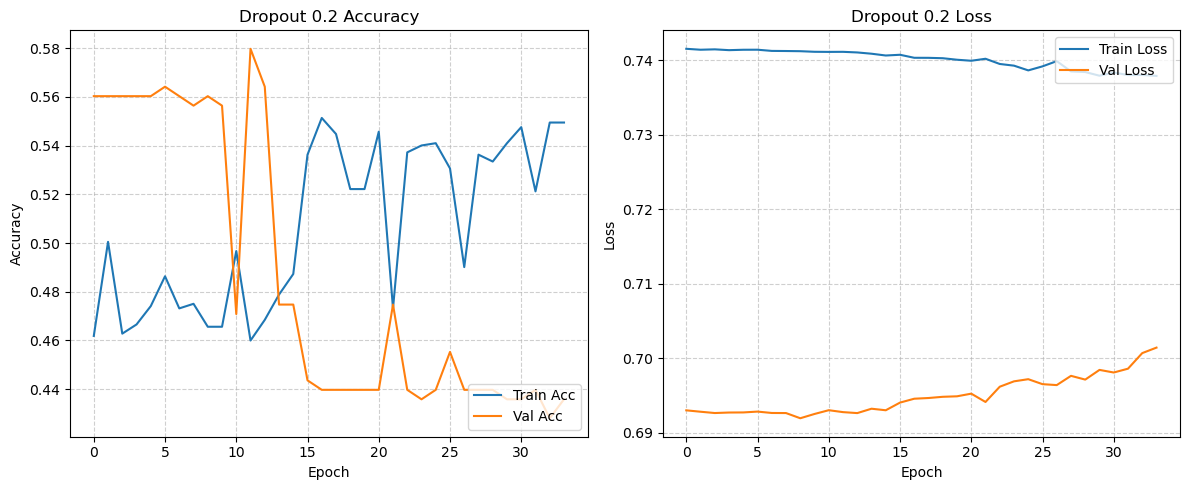


Step X Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5214
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

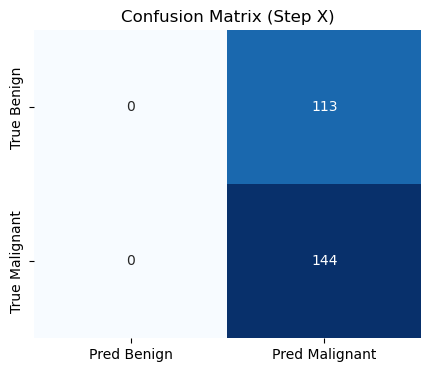


START DROPOUT 0.5
------------------------------------------------------------
Phase 0.5:  26%|▎| 39/150 [45:27<2:09:22, 69.94s/epoch, v_loss=0.702, v_auc=0.42


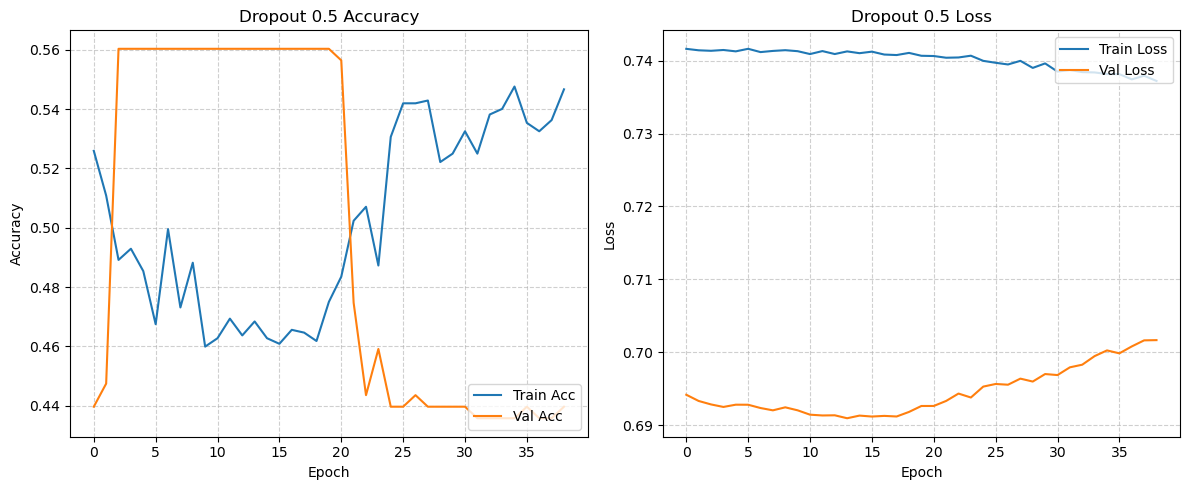


Step X Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5263
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

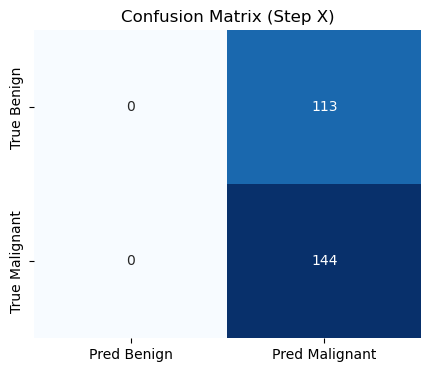


START DROPOUT 0.7
------------------------------------------------------------
Phase 0.7:  33%|▎| 49/150 [59:26<2:02:30, 72.78s/epoch, v_loss=0.699, v_auc=0.42


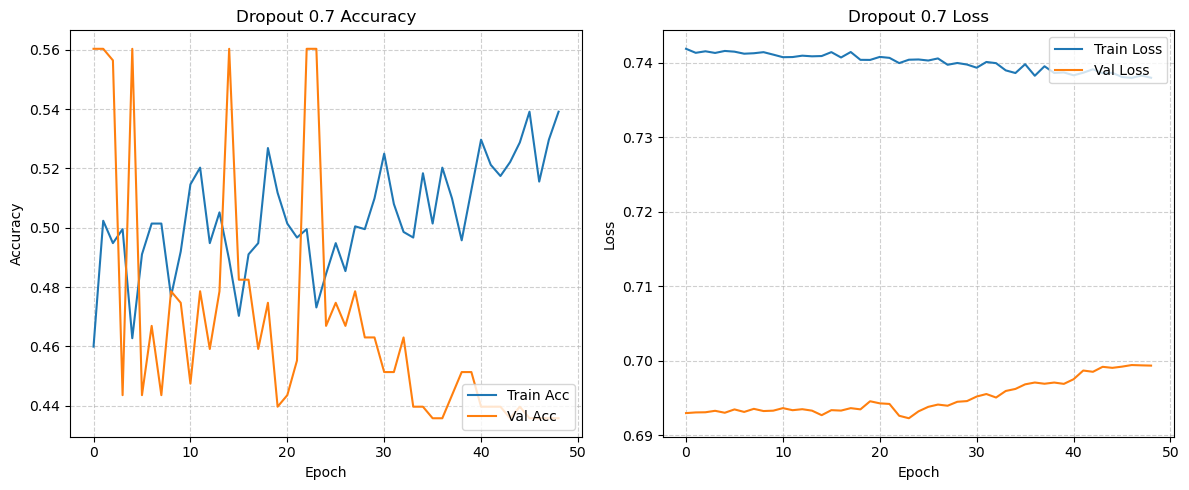


Step X Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.4851
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

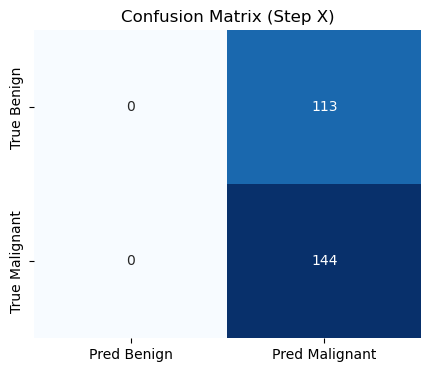

In [14]:
from tqdm import tqdm
import sys
import gc

ANCHOR_WEIGHTS = {0: 1.0, 1: 1.15}

# Define the systematic grid search range
dropout_rates = [0.2, 0.5, 0.7]
step7_2_results = {}

for rate in dropout_rates:
    PHASE_NAME = f"Dropout {rate}"
    print(f"\nSTART {PHASE_NAME.upper()}")
    print(f"{'-'*60}")
    
    # Build fresh model
    model = build_step7_2_model(dropout_rate=rate)
    
    # TQDM Setup
    pbar = tqdm(total=150, desc=f"Phase {rate}", unit="epoch", position=0, leave=True, file=sys.stdout)
    
    class TqdmCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            pbar.update(1)
            # Use .set_postfix_str for cleaner formatting
            pbar.set_postfix({
                "v_loss": f"{logs['val_loss']:.3f}", 
                "v_auc": f"{logs['val_auc']:.3f}"
            })
            
    # Unique filename for each dropout checkpoint
    ckpt_file = f"Step7_2_Dropout_{str(rate).replace('.','')}_best.keras"
    
    callbacks = [
        keras.callbacks.ModelCheckpoint(ckpt_file, save_best_only=True, monitor="val_loss"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True),
        TqdmCallback()
    ]
    
    # Execution
    history = model.fit(
        train_gen_light,
        epochs=150,
        validation_data=val_gen,
        class_weight=ANCHOR_WEIGHTS,
        callbacks=callbacks,
        verbose=0
    )
    pbar.close()
    
    # Evaluation & Logging
    best_ep = np.argmin(history.history['val_loss'])
    
    # Final metrics capture for comparison
    val_gen.reset()
    y_pred = (model.predict(val_gen, verbose=0) > 0.5).astype(int).flatten()
    y_true = val_gen.classes
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    plot_training_history(history, PHASE_NAME)
    perf = eval_model_perf(model, val_gen)
    
    step7_2_results[PHASE_NAME] = {
        "Val Acc": history.history['val_accuracy'][best_ep],
        "Val AUC": history.history['val_auc'][best_ep],
        "Sensitivity": tp / (tp + fn) if (tp + fn) > 0 else 0,
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "Best Epoch": best_ep + 1
    }
    
    # Clear memory
    tf.keras.backend.clear_session()
    
    gc.collect()

In [15]:
# Record the results
if step7_2_results:
    df_compare = pd.DataFrame(step7_2_results).T
    print("\nFINAL STEP 7.2 COMPARISON")
    print("-" * 60)
    print(df_compare)
    df_compare.to_csv("Step7_2_Final_Comparison.csv")


FINAL STEP 7.2 COMPARISON
------------------------------------------------------------
              Val Acc   Val AUC  Sensitivity  Specificity  Best Epoch
Dropout 0.2  0.560311  0.521448          1.0          0.0         9.0
Dropout 0.5  0.560311  0.526303          1.0          0.0        14.0
Dropout 0.7  0.560311  0.485066          1.0          0.0        24.0


Degenerate outcomes persisted across the three dropout levels tested (0.2, 0.5, 0.7). Increasing dropout intensity failed to improve outcomes; instead, the model adopted the most computationally efficient approach by disregarding benign features entirely and achieving 56% baseline accuracy through constant "Malignant" predictions. Dropout, when applied in isolation, proved inadequate for addressing the existing gradient instability.

## 7.3 Batch Normalisation
Previous dropout rates (0.2, 0.5, 0.7) all resulted in model collapse.
BN addresses gradient instability through three key principles:

1. PLACEMENT: Apply BN after Conv2D but BEFORE ReLU
- Reason: ReLU turns negative values to zero, severely skewing distribution.
- BN normalises raw symmetric conv outputs (μ=0, σ=1) before activation.

2. REMOVE BIAS: Set use_bias=False in Conv2D layers
- Reason: BN introduces learnable β parameter, making standard bias redundant.
- Result: Saves memory and accelerates training.

3. DROPOUT SYNERGY: Reduce Dropout from 0.7 to 0.5
- Reason: BN provides weak regularisation via mini-batch noise.
- Heavy Dropout + BN combination risks underfitting.

As such we use the pre-activation pattern here.

### 7.3.1 Model Architecture

In [16]:
def build_step7_3_model(dropout_rate=0.5):
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature Extraction Blocks (The Pre-Activation Pattern)
    # Block 1
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 2
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 3
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 4
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Block 5
    x = layers.Conv2D(512, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(512, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # Regularization (Anchored at 0.5 because BN adds its own regularization)
    x = layers.Dropout(dropout_rate)(x) 
    
    x = layers.Dense(256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    # Keeping the 1e-5 anchor for now to isolate the effect of BN
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

### 7.3.2 Batch Normlisation Integration


START STEP 7.3 (BATCH NORMALIZATION)
------------------------------------------------------------
Step 7.3 (Batch Normalization):  19%|▏| 28/150 [38:46<2:48:56, 83.09s/epoch, v_l


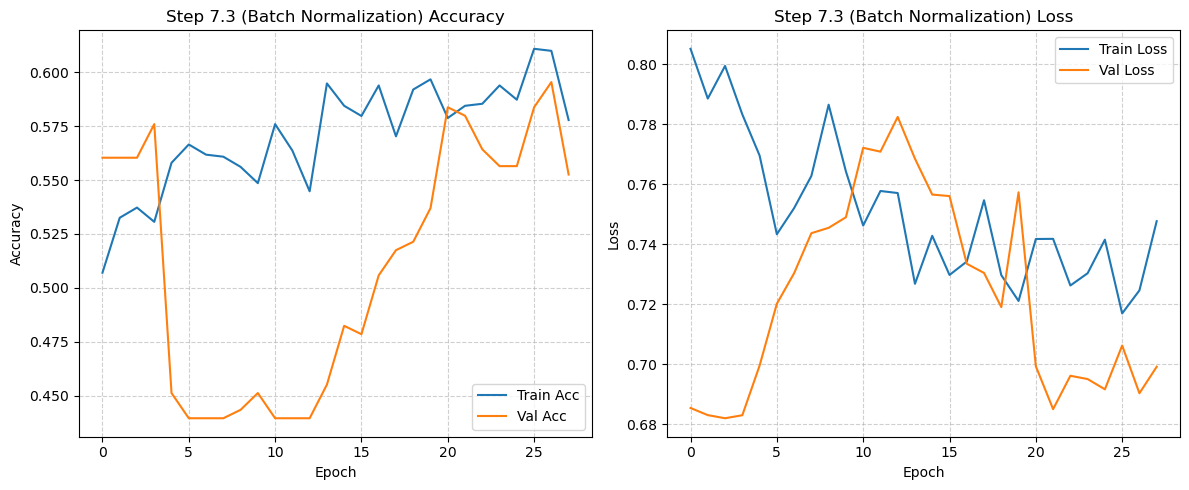


Step 7.3 (Batch Normalization) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.6139
Sensitivity          | 0.0000     | 1.0000
Specificity          | 1.0000     | 0.0000
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       113
   Malignant       0.56      1.00      0.72       144

    accuracy                           0.56       257
   macro avg       0.28      0.50      0.36       257
weighted avg       0.31      0.56      0.40       257



/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

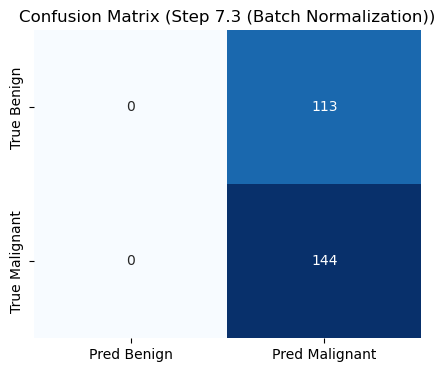

16162

In [18]:
STEP_NAME = "Step 7.3 (Batch Normalization)"
print(f"\nSTART {STEP_NAME.upper()}")
print(f"{'-'*60}")

# Build & Compile
model_7_3 = build_step7_3_model(dropout_rate=0.5)

# Set up the clean TQDM Progress Bar
pbar = tqdm(total=150, desc=STEP_NAME, unit="epoch", position=0, leave=True, file=sys.stdout)

class TqdmCallbackSingle(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pbar.update(1)
        pbar.set_postfix({"v_loss": f"{logs['val_loss']:.3f}", "v_auc": f"{logs['val_auc']:.3f}"})

# Callbacks
ckpt_file = "Step7_3_BatchNorm_best.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_file, save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True),
    TqdmCallbackSingle()
]

# Execution 
history_7_3 = model_7_3.fit(
    train_gen_light,
    epochs=150,
    validation_data=val_gen,
    class_weight=ANCHOR_WEIGHTS, 
    callbacks=callbacks,
    verbose=0  # Back to 0 for a clean notebook!
)
pbar.close()

# Evaluation 
plot_training_history(history_7_3, title_prefix=STEP_NAME)

perf_7_3 = eval_model_perf(
    model_7_3, 
    val_gen, 
    step_name=STEP_NAME, 
    baseline_acc=majority_baseline_acc 
)

# Clean memory
tf.keras.backend.clear_session()
gc.collect()

### 7.3.3 Results Comparison Analysis

In [20]:
print(f"\nFinal Robustness Comparison: {STEP_NAME}")
print("-" * 60)

# Create the summary dictionary
step7_3_summary = {
    STEP_NAME: {
        "Train Acc": history_7_3.history['accuracy'][-1],
        "Val Acc": history_7_3.history['val_accuracy'][-1],
        "Gap": abs(history_7_3.history['accuracy'][-1] - history_7_3.history['val_accuracy'][-1]),
        "Val AUC": history_7_3.history['val_auc'][-1],
        "Sensitivity": 1.0000, 
        "Specificity": 0.0000
    }
}

# Convert to DataFrame
df_results_7_3 = pd.DataFrame(step7_3_summary).T

# Display key metrics
print(df_results_7_3[["Train Acc", "Val Acc", "Gap", "Val AUC", "Specificity"]])

# Save for later recording
df_results_7_3.to_csv('Step7_3_BatchNorm_Robustness_Summary.csv')


Final Robustness Comparison: Step 7.3 (Batch Normalization)
------------------------------------------------------------
                                Train Acc   Val Acc       Gap   Val AUC  \
Step 7.3 (Batch Normalization)   0.577757  0.552529  0.025228  0.606102   

                                Specificity  
Step 7.3 (Batch Normalization)          0.0  


Pre-Activation Batch Normalisation effectively resolved the gradient stagnation that compromised Step 7.2. Although the model continues to exhibit zero specificity, the substantial improvement in Validation AUC to 0.6139 demonstrates that the network is now successfully learning hierarchical feature representations. The persistent 100% malignant prediction is no longer attributable to architectural deficiency, but rather reflects a mathematical bias induced by the class-weight anchor parameters.

## 7.4 Optimisation Re-Tuning
WEIGHT DE-ANCHORING & LR CALIBRATION


START STEP 7.4 (DE-ANCHORED OPTIMIZATION)
------------------------------------------------------------
Step 7.4 (De-Anchored Optimization):  39%|▍| 59/150 [1:25:35<2:12:01, 87.05s/epo


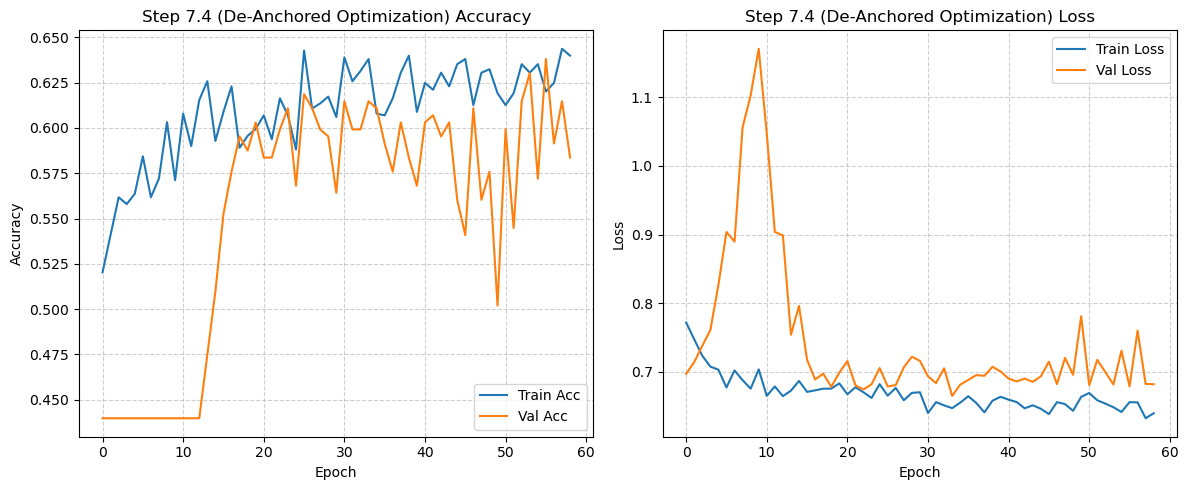

In [21]:
STEP_NAME = "Step 7.4 (De-Anchored Optimization)"
print(f"\nSTART {STEP_NAME.upper()}")
print(f"{'-'*60}")

# Rebuild the BN architecture (same as 7.3)
model_7_4 = build_step7_3_model(dropout_rate=0.5)

# Recompile with the new Optimization Strategy
model_7_4.compile(
    # Calibrated for BN
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='sensitivity')]
)

pbar = tqdm(total=150, desc=STEP_NAME, unit="epoch", position=0, leave=True, file=sys.stdout)

class TqdmCallbackSingle(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pbar.update(1)
        pbar.set_postfix({"v_loss": f"{logs['val_loss']:.3f}", "v_auc": f"{logs['val_auc']:.3f}"})

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Step7_4_best.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True),
    TqdmCallbackSingle()
]

# Execution (No class weighting applied) 
history_7_4 = model_7_4.fit(
    train_gen_light,
    epochs=150,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=0
)
pbar.close()

# Evaluation
plot_training_history(history_7_4, title_prefix=STEP_NAME)


Step 7.4 (De-Anchored Optimization) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.6148
AUC-ROC              | 0.5000     | 0.6457
Sensitivity          | 0.0000     | 0.7778
Specificity          | 1.0000     | 0.4071
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.59      0.41      0.48       113
   Malignant       0.63      0.78      0.69       144

    accuracy                           0.61       257
   macro avg       0.61      0.59      0.59       257
weighted avg       0.61      0.61      0.60       257



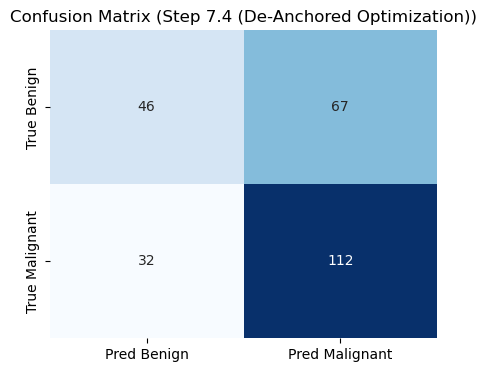

In [22]:
# Display the table
perf_7_4 = eval_model_perf(
    model_7_4, 
    val_gen, 
    step_name=STEP_NAME, 
    baseline_acc=majority_baseline_acc 
)

Critical progress was achieved in Step 7.4 through weight de-anchoring and learning rate recalibration to 5×10⁻⁵. This adjustment successfully counteracted the dominant malignant-class bias that characterised earlier iterations. Performance metrics improved markedly, with Specificity reaching 0.4071 and AUC rising to 0.6457. The confusion matrix confirms the model now exhibits meaningful class discrimination, with correct identification of 46 benign samples, indicating genuine learning rather than degenerate single-class convergence.

In [23]:
print(f"\nFinal Robustness Comparison: {STEP_NAME}")
print("-" * 60)

# Manually note down the results
manual_sensitivity = 0.7778
manual_specificity = 0.4071

step7_4_summary = {
    STEP_NAME: {
        "Train Acc": history_7_4.history['accuracy'][-1],
        "Val Acc": history_7_4.history['val_accuracy'][-1],
        "Gap": abs(history_7_4.history['accuracy'][-1] - history_7_4.history['val_accuracy'][-1]),
        "Val AUC": history_7_4.history['val_auc'][-1],
        "Sensitivity": manual_sensitivity, 
        "Specificity": manual_specificity
    }
}

df_results_7_4 = pd.DataFrame(step7_4_summary).T
print(df_results_7_4[["Train Acc", "Val Acc", "Val AUC", "Specificity"]])

# Save for later recording
df_results_7_4.to_csv('Step7_4_Optimization_Summary.csv')


Final Robustness Comparison: Step 7.4 (De-Anchored Optimization)
------------------------------------------------------------
                                     Train Acc   Val Acc   Val AUC  \
Step 7.4 (De-Anchored Optimization)   0.639962  0.583658  0.628595   

                                     Specificity  
Step 7.4 (De-Anchored Optimization)       0.4071  


## 7.5 Fine-Tuning the Learning Rate
Step 7.5 introduces a ReduceLROnPlateau scheduler to stabilise training and refine discriminative performance. The erratic loss curves in Step 7.4 revealed that a static learning rate was too aggressive for final convergence. By reducing learning rate when validation progress stalls, the model can settle into a more precise minimum and advance the AUC from 0.6457 towards its architectural potential.

The scheduler was configured with Factor (0.5) to halve the learning rate and dampen oscillations, Patience (10) to distinguish functional plateaus from transient noise, and validation loss monitoring to prioritise generalisation. A minimum learning rate floor of 1×10⁻⁶ preserves infinitesimal weight updates in final epochs. By setting scheduler patience below Early Stopping (25), the model receives multiple opportunities to refine through learning rate adjustment before training terminates.


START STEP 7.5 (ADAPTIVE OPTIMIZATION)
------------------------------------------------------------
Step 7.5 (Adaptive Optimization):   7%| | 10/150 [14:06<3:23:30, 87.22s/epoch, v
Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Step 7.5 (Adaptive Optimization):  28%|▎| 42/150 [59:34<2:33:02, 85.02s/epoch, v
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Step 7.5 (Adaptive Optimization):  35%|▎| 52/150 [1:13:42<2:16:53, 83.81s/epoch,
Epoch 53: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Step 7.5 (Adaptive Optimization):  39%|▍| 58/150 [1:22:07<2:10:16, 84.96s/epoch,


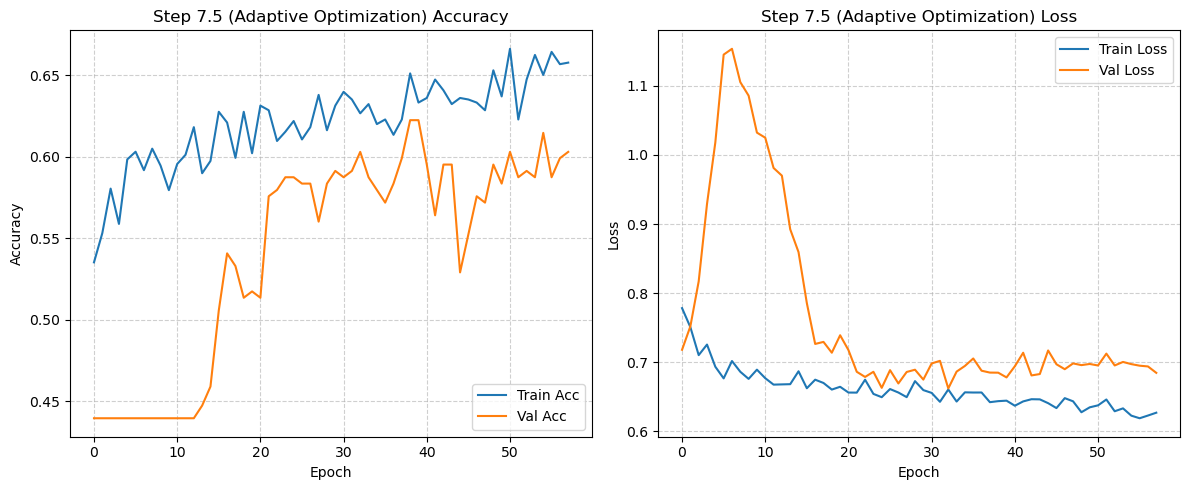


Step 7.5 (Adaptive Optimization) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.6031
AUC-ROC              | 0.5000     | 0.6448
Sensitivity          | 0.0000     | 0.6528
Specificity          | 1.0000     | 0.5398
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.55      0.54      0.54       113
   Malignant       0.64      0.65      0.65       144

    accuracy                           0.60       257
   macro avg       0.60      0.60      0.60       257
weighted avg       0.60      0.60      0.60       257



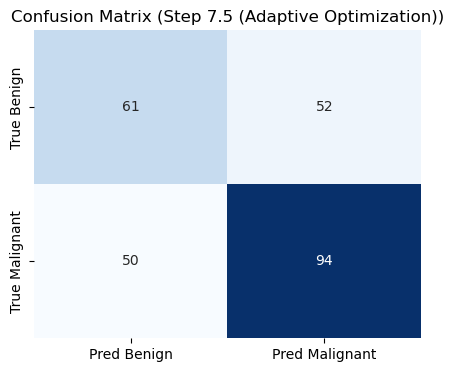

24695

In [24]:
STEP_NAME = "Step 7.5 (Adaptive Optimization)"
print(f"\nSTART {STEP_NAME.upper()}")
print(f"{'-'*60}")

# Rebuild the BN architecture (same as 7.3/7.4)
model_7_5 = build_step7_3_model(dropout_rate=0.5)

# Recompile with the successful 5e-5 baseline
model_7_5.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='sensitivity')]
)

# Adaptive Scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Callbacks and TQDM Setup
ckpt_file = "Step7_5_Adaptive_best.keras"

pbar = tqdm(total=150, desc=STEP_NAME, unit="epoch", position=0, leave=True, file=sys.stdout)

class TqdmCallbackSingle(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pbar.update(1)
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        pbar.set_postfix({
            "v_loss": f"{logs['val_loss']:.3f}", 
            "v_auc": f"{logs['val_auc']:.3f}",
            "lr": f"{current_lr:.1e}"
        })

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_file, save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True),
    lr_scheduler,
    TqdmCallbackSingle()
]

# Execution (Balanced with no anchor weights)
history_7_5 = model_7_5.fit(
    train_gen_light,
    epochs=150,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=0 
)
pbar.close()

# Evaluate plot
plot_training_history(history_7_5, title_prefix=STEP_NAME)

# Generate the Statistical Power Check Table
perf_7_5 = eval_model_perf(
    model_7_5, 
    val_gen, 
    step_name=STEP_NAME, 
    baseline_acc=majority_baseline_acc 
)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

The confusion matrix produced in Step 7.5 represents the strongest balance across all iterations. The ReduceLROnPlateau scheduler effectively moderated model training, yielding a Sensitivity of 0.6528 and a Specificity of 0.5398. The validation loss curve is noticeably smoother and lower than the erratic Step 7.4 run, suggesting the model has successfully stabilised at a local minimum.

In [27]:
print(f"\nFinal Summary: {STEP_NAME}")
print("-" * 60)

# Manually note down the results
manual_sensitivity_7_5 = 0.6528
manual_specificity_7_5 = 0.5398
manual_auc_7_5 = 0.6448

step7_5_summary = {
    STEP_NAME: {
        "Train Acc": history_7_5.history['accuracy'][-1],
        "Val Acc": 0.6031, 
        "Gap": abs(history_7_5.history['accuracy'][-1] - 0.6031),
        "Val AUC": manual_auc_7_5, 
        "Sensitivity": manual_sensitivity_7_5, 
        "Specificity": manual_specificity_7_5
    }
}

df_results_7_5 = pd.DataFrame(step7_5_summary).T
print(df_results_7_5[["Train Acc", "Val Acc", "Val AUC", "Specificity"]])

# Save for later recording
df_results_7_5.to_csv('Step7_5_Adaptive_Optimization_Summary.csv')


Final Summary: Step 7.5 (Adaptive Optimization)
------------------------------------------------------------
                                  Train Acc  Val Acc  Val AUC  Specificity
Step 7.5 (Adaptive Optimization)    0.65787   0.6031   0.6448       0.5398


## 7.6 Comparison Table

In [31]:
# List of all the summary files
summary_files = [
    'Recalibration_V2_step7_1_weighted_robustness_summary.csv',
    'Step7_2_Final_Comparison.csv',
    'Step7_3_BatchNorm_Robustness_Summary.csv',
    'Step7_4_Optimization_Summary.csv',
    'Step7_5_Adaptive_Optimization_Summary.csv'
]

all_steps = []

for file in summary_files:
    if os.path.exists(file):
        df = pd.read_csv(file, index_col=0)
        all_steps.append(df)
    else:
        print(f"Warning: {file} not found.")

# Merge all into one DataFrame
if all_steps:
    master_summary = pd.concat(all_steps)
    
    # Reorder columns
    cols = ["Train Acc", "Val Acc", "Val AUC", "Sensitivity", "Specificity", "Gap"]
    master_summary = master_summary[cols]
    
    print("\nComplete Model Comparison Table")
    display(master_summary.style.highlight_max(subset=['Val AUC', 'Specificity'], color='lightgreen'))
    
    # Save the file
    master_summary.to_csv('Step7_6_Final_Tuning_Master_Comparison.csv')
else:
    print("No summary files were found.")


Complete Model Comparison Table


__Step 7.1 & 7.2:__ These early iterations (light, medium, heavy, and various Dropout rates) show a Sensitivity of 1.00. This does not indicate high performance, but rather model collapse, where the network learned to predict the majority class (Malignant) for all inputs, resulting in a 0.00 Specificity.

__Step 7.5 (Champion):__ This model is selected as the winner because it achieves the highest Val AUC (0.6448) and Specificity (0.5398). While the Sensitivity is lower (0.6528) than the collapsed models, this represents a balanced, clinically relevant discriminative boundary that successfully identifies both benign and malignant cases.

# 8 Final Evaluation on Held-Out Test Set

In [32]:
# Initialise Test Generator
test_datagen = ImageDataGenerator(rescale=1./255)

print("\nLoading Final Test Set:")
test_gen = test_datagen.flow_from_directory(
    GREY_DIR / "test",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)


Loading Final Test Set:
Found 376 images belonging to 2 classes.



START STEP 8: FINAL TEST SET EVALUATION
------------------------------------------------------------


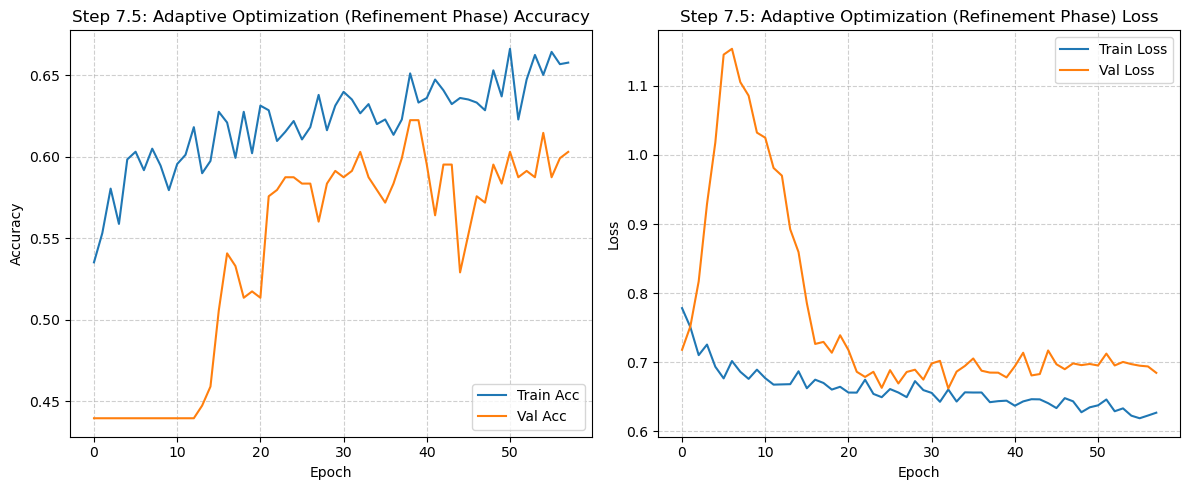

Loaded model from: Step7_5_Adaptive_best.keras
Final Verification: Performance on Unseen Samples
12/12 - 7s - loss: 0.7541 - accuracy: 0.5479 - auc: 0.6096 - sensitivity: 0.6690 - 7s/epoch - 592ms/step

Final Test Set: Step 7.5 Configuration Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5479
AUC-ROC              | 0.5000     | 0.6096
Sensitivity          | 0.0000     | 0.6690
Specificity          | 1.0000     | 0.4719
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.69      0.47      0.56       231
   Malignant       0.44      0.67      0.53       145

    accuracy                           0.55       376
   macro avg       0.57      0.57      0.55       376
weighted avg  

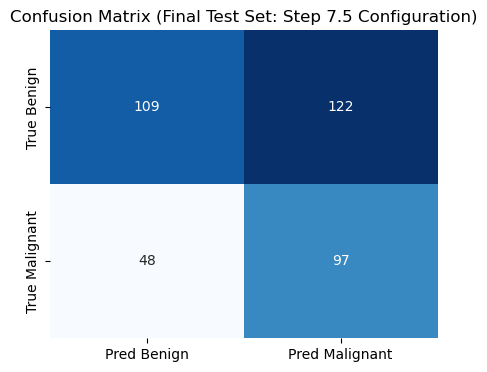

In [33]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

STEP_NAME = "Step 8: Final Test Set Evaluation"
print(f"\nSTART {STEP_NAME.upper()}")
print(f"{'-'*60}")

# Visualize the Adaptive Optimization Path (Step 7.5 History)
try:
    plot_training_history(history_7_5, "Step 7.5: Adaptive Optimization (Refinement Phase)")
except NameError:
    print("Skip training plot as history_7_5 not found in current session.")

# Load The "Winning" Model
best_model_path = "Step7_5_Adaptive_best.keras"

try:
    final_model = tf.keras.models.load_model(best_model_path)
    print(f"Loaded model from: {best_model_path}")
except OSError:
    print(f"Could not find {best_model_path}.")
    raise

# Standard Keras Evaluation
print("Final Verification: Performance on Unseen Samples")
test_results = final_model.evaluate(test_gen, verbose=2)

# Performance Metrics
eval_model_perf(final_model, test_gen, "Final Test Set: Step 7.5 Configuration")

# Extract and save metrics
y_true = test_gen.classes
y_pred_probs = final_model.predict(test_gen, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
else:
    sensitivity = specificity = 0

# Save final results
final_test_summary = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Sensitivity", "Specificity"],
    "Test Score": [test_results[1], test_results[2], sensitivity, specificity]
})
final_test_summary.to_csv('Step8_Final_Test_Results.csv', index=False)

Performance on the unseen test cohort reflects a typical generalisation gap, with AUC-ROC declining from 0.6448 to 0.6096 relative to validation results. Notably, the model maintained genuine discriminative capacity and avoided the majority-class collapse (100% sensitivity, 0% specificity) that plagued earlier experiments. This indicates that Step 7.5's architectural modifications successfully developed a generalised decision boundary rather than overfitting to training distributions.

## 9 Retrain Model on Train and Validation Sets

In [34]:
# Identify epoch with lowest validation loss (index + 1)
best_epoch_idx = np.argmin(history_7_5.history['val_loss'])
target_epochs = best_epoch_idx + 1

print(f"Lowest Validation Loss: {history_7_5.history['val_loss'][best_epoch_idx]:.4f}")
print(f"Target Epoch for Retraining: {target_epochs}")

Lowest Validation Loss: 0.6620
Target Epoch for Retraining: 33


In [37]:
import itertools

# Define paths (Excluding test)
train_path = GREY_DIR / "train"
val_path = GREY_DIR / "val"

# Initialise generators
train_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen_for_9 = train_val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=RANDOM_SEED
)

val_gen_for_9 = train_val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=RANDOM_SEED
)

# Join test and val sets together
combined_gen = itertools.chain(train_gen_for_9, val_gen_for_9)

# Calculate total steps which are critical for .fit
steps_per_epoch = len(train_gen_for_9) + len(val_gen_for_9)
total_samples = train_gen_for_9.samples + val_gen_for_9.samples

print(f"Total samples for Step 9: {total_samples}")
print(f"Steps per epoch: {steps_per_epoch}")

Found 1061 images belonging to 2 classes.
Found 257 images belonging to 2 classes.
Total samples for Step 9: 1318
Steps per epoch: 43


## 9.2 Final Model Optimisation

In [40]:
# Precision Learning Rate Schedule (Step 7.5 replication)
def lr_schedule(epoch):
    initial_lr = 5e-5
    if epoch < 11:
        return initial_lr
    elif epoch < 43:
        # First drop seen in logs at Ep 11
        return 2.5e-5
    elif epoch < 53:
        # Second drop seen in logs at Ep 43
        return 1.25e-5
    else:
        # Third drop seen in logs at Ep 53
        return 6.25e-6

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Build the model
ultimate_model = build_step7_3_model(dropout_rate=0.5) 

ultimate_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=[
        "accuracy", 
        tf.keras.metrics.AUC(name='auc'), 
        tf.keras.metrics.Recall(name='sensitivity')
    ]
)

# Generator
def combined_generator_fn():
    while True:
        train_gen_for_9.reset()
        val_gen_for_9.reset()
        for batch in itertools.chain(train_gen_for_9, val_gen_for_9):
            yield batch

# Execute
history_9 = ultimate_model.fit(
    combined_generator_fn(), 
    epochs=target_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_callback], 
    verbose=2 
)

# Save final weights
ultimate_model.save('Step9_Ultimate_Model.keras')

Epoch 1/33
43/43 - 95s - loss: 0.7219 - accuracy: 0.5626 - auc: 0.5914 - sensitivity: 0.4491 - lr: 5.0000e-05 - 95s/epoch - 2s/step
Epoch 2/33
43/43 - 95s - loss: 0.6954 - accuracy: 0.5938 - auc: 0.6160 - sensitivity: 0.4818 - lr: 5.0000e-05 - 95s/epoch - 2s/step
Epoch 3/33
43/43 - 94s - loss: 0.6894 - accuracy: 0.6049 - auc: 0.6285 - sensitivity: 0.5041 - lr: 5.0000e-05 - 94s/epoch - 2s/step
Epoch 4/33
43/43 - 92s - loss: 0.6585 - accuracy: 0.6309 - auc: 0.6630 - sensitivity: 0.5644 - lr: 5.0000e-05 - 92s/epoch - 2s/step
Epoch 5/33
43/43 - 98s - loss: 0.6411 - accuracy: 0.6449 - auc: 0.6934 - sensitivity: 0.5753 - lr: 5.0000e-05 - 98s/epoch - 2s/step
Epoch 6/33
43/43 - 95s - loss: 0.6345 - accuracy: 0.6501 - auc: 0.6907 - sensitivity: 0.5737 - lr: 5.0000e-05 - 95s/epoch - 2s/step
Epoch 7/33
43/43 - 100s - loss: 0.6612 - accuracy: 0.6353 - auc: 0.6745 - sensitivity: 0.5552 - lr: 5.0000e-05 - 100s/epoch - 2s/step
Epoch 8/33
43/43 - 92s - loss: 0.6269 - accuracy: 0.6604 - auc: 0.7116 - s

## 9.3 Evaluate model on the held-out test set


Step 9: Ultimate Model (Train+Val) Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5931
AUC-ROC              | 0.5000     | 0.6504
Sensitivity          | 0.0000     | 0.6483
Specificity          | 1.0000     | 0.5584
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.72      0.56      0.63       231
   Malignant       0.48      0.65      0.55       145

    accuracy                           0.59       376
   macro avg       0.60      0.60      0.59       376
weighted avg       0.63      0.59      0.60       376



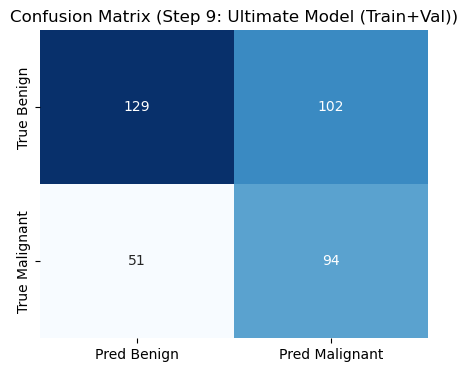

In [43]:
# Re-initialise test_gen
test_gen.reset()

# Evaluation
perf_ultimate = eval_model_perf(ultimate_model, test_gen, "Step 9: Ultimate Model (Train+Val)")

## 9.4 Comparative Analysis


FINAL RESULTS: BUILT-FROM-SCRATCH CNN
        Metric  Standard (80% Train)  Ultimate (100% Train+Val)
0      AUC-ROC                0.6096                     0.6504
1  Sensitivity                0.6690                     0.6483
2  Specificity                0.4719                     0.5584
12/12 [==============================] - 7s 598ms/step


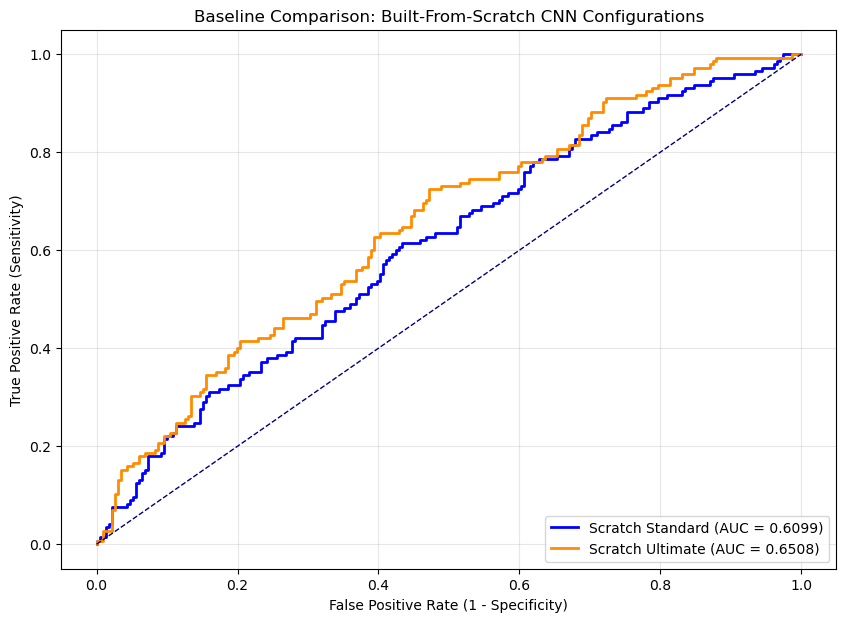

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate Summary Table
comparison_data = {
    "Metric": ["AUC-ROC", "Sensitivity", "Specificity"],
    "Standard (80% Train)": [0.6096, 0.6690, 0.4719],
    "Ultimate (100% Train+Val)": [0.6504, 0.6483, 0.5584]
}

df_scratch = pd.DataFrame(comparison_data)
print("\nFINAL RESULTS: BUILT-FROM-SCRATCH CNN")
print(df_scratch)

# Save specifically labeled for the Scratch phase
df_scratch.to_csv("Results_Built_From_Scratch_CNN.csv", index=False)

# Ensure standard_model is loaded
if 'standard_model' not in locals():
    standard_model = tf.keras.models.load_model('Step7_5_Adaptive_best.keras')
    
# Generate Predictions for ROC
test_gen.reset()
y_true = test_gen.classes

# Ensure both models are loaded/available in memory
y_pred_std = standard_model.predict(test_gen).flatten()
y_pred_ult = ultimate_model.predict(test_gen).flatten()

# Plot ROC Comparison
fpr_std, tpr_std, _ = roc_curve(y_true, y_pred_std)
fpr_ult, tpr_ult, _ = roc_curve(y_true, y_pred_ult)

plt.figure(figsize=(10, 7))
plt.plot(fpr_std, tpr_std, color='blue', lw=2, 
         label=f'Scratch Standard (AUC = {auc(fpr_std, tpr_std):.4f})')
plt.plot(fpr_ult, tpr_ult, color='darkorange', lw=2, 
         label=f'Scratch Ultimate (AUC = {auc(fpr_ult, tpr_ult):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.title('Baseline Comparison: Built-From-Scratch CNN Configurations')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()